In [1]:
import os
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive', force_remount=True)

# Create a folder in the root directory
!mkdir -p "/content/drive/My Drive/My Folder/Dataset"
!mkdir -p "/content/drive/My Drive/My Folder/Saved Models/Pretrained Models"
!mkdir -p "/content/drive/My Drive/My Folder/Saved Models/Pretrained Models"


Mounted at /content/drive


In [2]:
!pip install torch torchvision transformers scikit-learn datasets huggingface-hub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 7.3 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [3]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from transformers import AutoModelForSequenceClassification, AutoTokenizer, AutoModel, AdamW
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from datasets import Dataset, load_dataset
import pandas as pd
import numpy as np
import re
from huggingface_hub import hf_hub_download
import json
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
print('Using PyTorch version:', torch.__version__)
if torch.cuda.is_available():
    print('Using GPU, device name:', torch.cuda.get_device_name(0))
    device = torch.device('cuda')
else:
    print('No GPU found, using CPU instead.')
    device = torch.device('cpu')

Using PyTorch version: 2.5.1+cu121
No GPU found, using CPU instead.


#Params

In [5]:
num_classes = 2

In [6]:
learning_rate = 2e-5
batch_size = 64
epochs = 10
patience = 2

#Normalization

In [15]:
class Normalize:
    #Function to keep English and Bangla
    def normalize_script(self, text):
        # Keeping Bangla and English characters, removing others
        text = re.sub(r"[^\u0980-\u09FFa-zA-Z\s]", "", text)
        return text

    # Function to remove emojis
    def remove_emojis(self, text):
        emoji_pattern = re.compile(
            "["
            "\U0001F600-\U0001F64F"  # Emoticons
            "\U0001F300-\U0001F5FF"  # Symbols & pictographs
            "\U0001F680-\U0001F6FF"  # Transport & map symbols
            "\U0001F700-\U0001F77F"  # Alchemical symbols
            "\U0001F780-\U0001F7FF"  # Geometric shapes extended
            "\U0001F800-\U0001F8FF"  # Supplemental arrows-C
            "\U0001F900-\U0001F9FF"  # Supplemental symbols and pictographs
            "\U0001FA00-\U0001FA6F"  # Chess symbols
            "\U0001FA70-\U0001FAFF"  # Symbols and pictographs extended-A
            "\U00002702-\U000027B0"  # Dingbats
            "\U000024C2-\U0001F251"  # Enclosed characters
            "]+",
            flags=re.UNICODE
        )
        return emoji_pattern.sub(r'', text)

    # Function to remove URLs
    def remove_urls(self, text):
        url_pattern = re.compile(r"https?://\S+|www\.\S+")
        return url_pattern.sub(r'', text)

    # Function to remove special characters and retain Bangla text
    def remove_special_characters(self, text):
        # Keep Bangla characters, digits, and some punctuation
        return re.sub(r"[^ঀ-৿০-৯a-zA-Z\s.,!?]", "", text)

    # Function to normalize whitespace
    def normalize_whitespace(self, text):
        return re.sub(r"\s+", " ", text).strip()

    # Function to remove HTML tags from text
    def remove_html_tags(self,text):
        pattern = re.compile('<.*?>')
        return pattern.sub(r'', text)

    # Function to convert English digits to Bangla digits
    def convert_english_to_bangla_digits(self, text):
        english_to_bangla_digit_map = str.maketrans("0123456789", "০১২৩৪৫৬৭৮৯")
        return text.translate(english_to_bangla_digit_map)

    # Function to normalize text
    def normalize_text(self, text):
        text = self.remove_html_tags(text)  # Remove HTML tags
        text = self.normalize_script(text)  # Keep Bangla and English characters
        text = self.remove_emojis(text)  # Remove emojis
        text = self.remove_urls(text)  # Remove URLs
        text = self.remove_special_characters(text)  # Remove special characters
        text = self.normalize_whitespace(text)  # Normalize whitespace
        text = self.convert_english_to_bangla_digits(text)  # Convert English digits to Bangla digits
        return text

#30k Dataset

In [9]:
# Load the dataset
df = pd.read_csv("hf://datasets/nadiaafsara/Bhs-Kag/BSH_Kag_30k.csv")

In [10]:
df.columns

Index(['sentence', 'hate', 'category'], dtype='object')

In [11]:
df = df.rename(columns={'sentence': 'text', 'hate': 'label'})  # Adjusting columns

In [12]:
df.columns

Index(['text', 'label', 'category'], dtype='object')

In [13]:
for i in range(100):
  print(df.text[i])

যত্তসব পাপন শালার ফাজলামী!!!!!
পাপন শালা রে রিমান্ডে নেওয়া দরকার
জিল্লুর রহমান স্যারের ছেলে এতো বড় জারজ হবে এটা একটা দেশের মানুষ কোনো দিন ও ভাবতে পারেনি।ধন্যবাদ তাহসিন ভাই।
শালা লুচ্চা দেখতে পাঠার মত দেখা যায়
তুই তো শালা গাজা খাইছচ।তুর মার হেডায় খেলবে সাকিব
এটা কুন দরনের কেলা ফাইজলামি তাস্কিন রে চর মারা দরকার
পাপন ভর মাদা চোদ পাপনে পদতেক চাই
দুরো সালার পুদ চুপথাক
কুত্তার বাছচা পাপন
বাল ছাল তর সাউয়া😡
তোর কপালে জুতা মারি শালার পুত
পাপনে পাগল হয়াছে
দেখেছো মাগি না হিজরা বোঝা যাচ্ছে না। দেখে মনে হচ্ছে হিজরা
হালার পু পাপন
শালায় এই কারণেই খেলায় ডাব্বা মারে😡😠
ব্ব
পাপন হালারে বেট থেকে জুতার মালা দিয়এই বের করে না কেনে ওর কারনে ভাল পিলিআর গুলো খেলা পারেনা
পাপন মাঘির পুতের পেটের মদ্দে দুর্নিতি ভরা
পাপনকে জুতার মালা দেয়া জরুর
আমি হলে তো জারসি পড়া লোকটাকে চুদেদিতাম
ইয়েছির আলী হালা খেলা জানেনা
কুত্তার বাচ্চা পাপন
পাপন মাগির পোলার এটা করছে
মাগির পুয়া
ক্রিকেট মনে হয় ওনার বাবার সম্পত্তি হালার ফু
বিসিবির সবকটাই চোরমাদারচোদ
কুকুরের চাচ্চা তদেক কি হয়চে নবীকে গারি দিয়াচে তদেক কিচু হয়নি। আর সাদারন একটা মানু

In [16]:
df = df.dropna()  # Removing any rows with missing values
l = len(df.text)
n = Normalize()

for i in range (l):
    text = df.text[i]
    ct = n.normalize_text(text)
    if ct=='':
        df = df.drop([i])#Dropping empty row
    else:
        df.loc[i,'text'] = ct


In [17]:
for i in range(100):
  print(df.text[i])

যত্তসব পাপন শালার ফাজলামী
পাপন শালা রে রিমান্ডে নেওয়া দরকার
জিল্লুর রহমান স্যারের ছেলে এতো বড় জারজ হবে এটা একটা দেশের মানুষ কোনো দিন ও ভাবতে পারেনিধন্যবাদ তাহসিন ভাই
শালা লুচ্চা দেখতে পাঠার মত দেখা যায়
তুই তো শালা গাজা খাইছচতুর মার হেডায় খেলবে সাকিব
এটা কুন দরনের কেলা ফাইজলামি তাস্কিন রে চর মারা দরকার
পাপন ভর মাদা চোদ পাপনে পদতেক চাই
দুরো সালার পুদ চুপথাক
কুত্তার বাছচা পাপন
বাল ছাল তর সাউয়া
তোর কপালে জুতা মারি শালার পুত
পাপনে পাগল হয়াছে
দেখেছো মাগি না হিজরা বোঝা যাচ্ছে না দেখে মনে হচ্ছে হিজরা
হালার পু পাপন
শালায় এই কারণেই খেলায় ডাব্বা মারে
ব্ব
পাপন হালারে বেট থেকে জুতার মালা দিয়এই বের করে না কেনে ওর কারনে ভাল পিলিআর গুলো খেলা পারেনা
পাপন মাঘির পুতের পেটের মদ্দে দুর্নিতি ভরা
পাপনকে জুতার মালা দেয়া জরুর
আমি হলে তো জারসি পড়া লোকটাকে চুদেদিতাম
ইয়েছির আলী হালা খেলা জানেনা
কুত্তার বাচ্চা পাপন
পাপন মাগির পোলার এটা করছে
মাগির পুয়া
ক্রিকেট মনে হয় ওনার বাবার সম্পত্তি হালার ফু
বিসিবির সবকটাই চোরমাদারচোদ
কুকুরের চাচ্চা তদেক কি হয়চে নবীকে গারি দিয়াচে তদেক কিচু হয়নি আর সাদারন একটা মানুষকে গারিদিয়েচ

Converting dataframe to huggingface dataset

In [ ]:
dataset = Dataset.from_pandas(df)

#Split Dataset

In [ ]:
dataset = dataset.train_test_split(test_size=0.2)
test_data = dataset["test"].train_test_split(test_size=0.5)
train_data = dataset["train"]
valid_data = test_data["train"]
test_data = test_data["test"]

In [ ]:
print(len(train_data))
print(len(valid_data))
print(len(test_data))

23994
2999
3000


#Train with Early stopping

In [ ]:
class EarlyStopping:
    def __init__(self, patience=patience, mode="max", delta=0.001):
        self.patience = patience
        self.mode = mode
        self.delta = delta
        self.best_metric = None
        self.counter = 0
        self.stop_training = False

    def __call__(self, current_metric):
        if self.best_metric is None or (
            self.mode == "min" and current_metric < self.best_metric - self.delta
        ) or (
            self.mode == "max" and current_metric > self.best_metric + self.delta
        ):
            self.best_metric = current_metric
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.stop_training = True

In [ ]:
def compute_metrics(predictions, labels):
    acc = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average="weighted")
    precision = precision_score(labels, predictions, average="weighted")
    recall = recall_score(labels, predictions, average="weighted")
    return acc, f1, precision, recall

#BCL-HSD

In [ ]:
bcl_acc_train = []
bcl_f1_train = []
bcl_pre_train = []
bcl_rec_train = []
bcl_acc_val = []
bcl_f1_val = []
bcl_pre_val = []
bcl_rec_val = []

#Hybrid Model

In [7]:
class BertCNNBiLSTM(nn.Module):
    def __init__(self, bert_model_name, num_classes):
        super(BertCNNBiLSTM, self).__init__()
        self.bert = AutoModel.from_pretrained(bert_model_name)
        self.cnn = nn.Conv1d(in_channels=768, out_channels=128, kernel_size=3, padding=1)
        self.lstm = nn.LSTM(input_size=128, hidden_size=64, num_layers=1, bidirectional=True, batch_first=True)
        self.fc = nn.Linear(64 * 2, num_classes)
        self.dropout = nn.Dropout(0.3)

    def forward(self, input_ids, attention_mask):
        bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        hidden_states = bert_output.last_hidden_state
        cnn_output = self.cnn(hidden_states.transpose(1, 2))
        lstm_output, _ = self.lstm(cnn_output.transpose(1, 2))
        pooled_output = lstm_output[:, -1, :]
        output = self.fc(self.dropout(pooled_output))
        return output

Load Tokenizer

In [ ]:
# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained("csebuetnlp/banglabert")

tokenizer_config.json:   0%|          | 0.00/119 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/528k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

#Tokenization

In [ ]:
# Tokenize the dataset
def tokenize_data(samples):
    return tokenizer(
        samples["text"],
        truncation=True,
        padding="max_length",
        max_length=128
    )

In [ ]:
# Apply tokenization to the datasets
train_data = train_data.map(tokenize_data, batched=True)
valid_data = valid_data.map(tokenize_data, batched=True)
test_data = test_data.map(tokenize_data, batched=True)

Map:   0%|          | 0/23994 [00:00<?, ? examples/s]

Map:   0%|          | 0/2999 [00:00<?, ? examples/s]

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

In [ ]:
print(train_data.column_names)
print(valid_data.column_names)
print(test_data.column_names)

['text', 'label', 'category', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask']
['text', 'label', 'category', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask']
['text', 'label', 'category', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask']


In [ ]:
# Remove unnecessary columns
train_data.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
valid_data.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
test_data.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

#DataLoaders

In [ ]:
# Define DataLoader
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=batch_size)

#Initialize Model

In [8]:
# Initialize the model, criterion, and optimizer
model = BertCNNBiLSTM("csebuetnlp/banglabert", num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=learning_rate)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/586 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/443M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


#Train Model

In [ ]:
def train_model_with_early_stopping_and_metrics(
    model, train_loader, valid_loader, criterion, optimizer, epochs=epochs, patience=patience
):
    early_stopping = EarlyStopping(patience=patience, mode="max")  # Monitoring validation accuracy
    best_model_state = None
    best_epoch = 0

    for epoch in range(epochs):
        # Training phase
        model.train()
        train_predictions, train_labels = [], []
        total_loss = 0

        for batch in train_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            # Collect predictions and labels
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            train_predictions.extend(preds)
            train_labels.extend(labels.cpu().numpy())

        train_acc, train_f1, train_precision, train_recall = compute_metrics(train_predictions, train_labels)
        bcl_acc_train.append(train_acc )
        bcl_f1_train.append(train_f1)
        bcl_pre_train.append(train_precision)
        bcl_rec_train.append(train_recall)
        print(
            f"Epoch {epoch + 1}/{epochs}, Training Loss: {total_loss / len(train_loader):.4f}, "
            f"Accuracy: {train_acc:.4f}, F1: {train_f1:.4f}, Precision: {train_precision:.4f}, Recall: {train_recall:.4f}"
        )

        # Validation phase
        model.eval()
        valid_predictions, valid_labels = [], []
        valid_loss = 0

        with torch.no_grad():
            for batch in valid_loader:
                input_ids = batch["input_ids"].to(device)
                attention_mask = batch["attention_mask"].to(device)
                labels = batch["label"].to(device)
                outputs = model(input_ids, attention_mask)
                loss = criterion(outputs, labels)
                valid_loss += loss.item()

                # Collect predictions and labels
                preds = torch.argmax(outputs, dim=1).cpu().numpy()
                valid_predictions.extend(preds)
                valid_labels.extend(labels.cpu().numpy())

        valid_acc, valid_f1, valid_precision, valid_recall = compute_metrics(valid_predictions, valid_labels)
        bcl_acc_val.append(valid_acc)
        bcl_f1_val.append(valid_f1)
        bcl_pre_val.append(valid_precision)
        bcl_rec_val.append(valid_recall)
        print(
            f"Epoch {epoch + 1}/{epochs}, Validation Loss: {valid_loss / len(valid_loader):.4f}, "
            f"Accuracy: {valid_acc:.4f}, F1: {valid_f1:.4f}, Precision: {valid_precision:.4f}, Recall: {valid_recall:.4f}"
        )

        # Early stopping check
        early_stopping(valid_acc)
        if early_stopping.stop_training:
            print(f"Early stopping triggered at epoch {epoch + 1}")
            break

        # Save the best model state
        if early_stopping.best_metric == valid_acc:
            best_model_state = model.state_dict()
            best_epoch = epoch + 1

    # Restore the best model state
    if best_model_state:
        model.load_state_dict(best_model_state)
        print(f"Loaded the best model from epoch {best_epoch}")

    return model

In [ ]:
# Train the model
trained_model = train_model_with_early_stopping_and_metrics(
    model, train_loader, valid_loader, criterion, optimizer, epochs=epochs, patience=patience
)

Epoch 1/10, Training Loss: 0.3482, Accuracy: 0.8595, F1: 0.8579, Precision: 0.8578, Recall: 0.8595
Epoch 1/10, Validation Loss: 0.2777, Accuracy: 0.8930, F1: 0.8937, Precision: 0.8952, Recall: 0.8930
Epoch 2/10, Training Loss: 0.2383, Accuracy: 0.9095, F1: 0.9095, Precision: 0.9094, Recall: 0.9095
Epoch 2/10, Validation Loss: 0.2740, Accuracy: 0.8906, F1: 0.8912, Precision: 0.8922, Recall: 0.8906
Epoch 3/10, Training Loss: 0.1934, Accuracy: 0.9265, F1: 0.9267, Precision: 0.9269, Recall: 0.9265
Epoch 3/10, Validation Loss: 0.2669, Accuracy: 0.8896, F1: 0.8906, Precision: 0.8930, Recall: 0.8896
Early stopping triggered at epoch 3
Loaded the best model from epoch 1


#Plot the Training and Validation Metrics




In [ ]:
os.makedirs("/content/drive/My Drive/My Folder/Saved Models/Pretrained Models/BCL-HSD-30k/Figures and Reports", exist_ok=True)

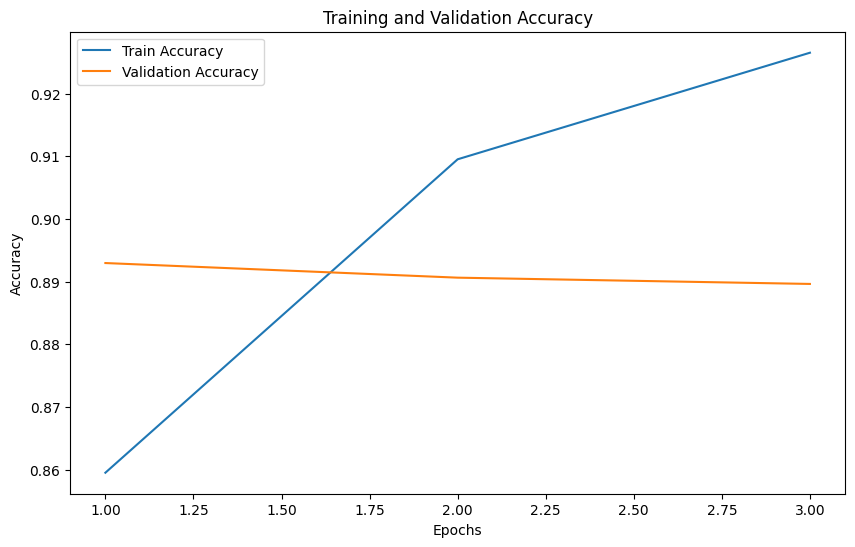

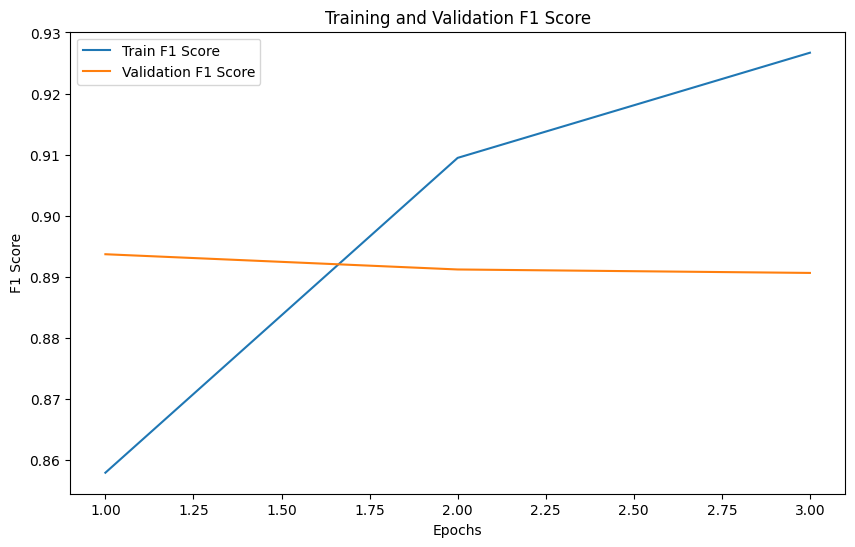

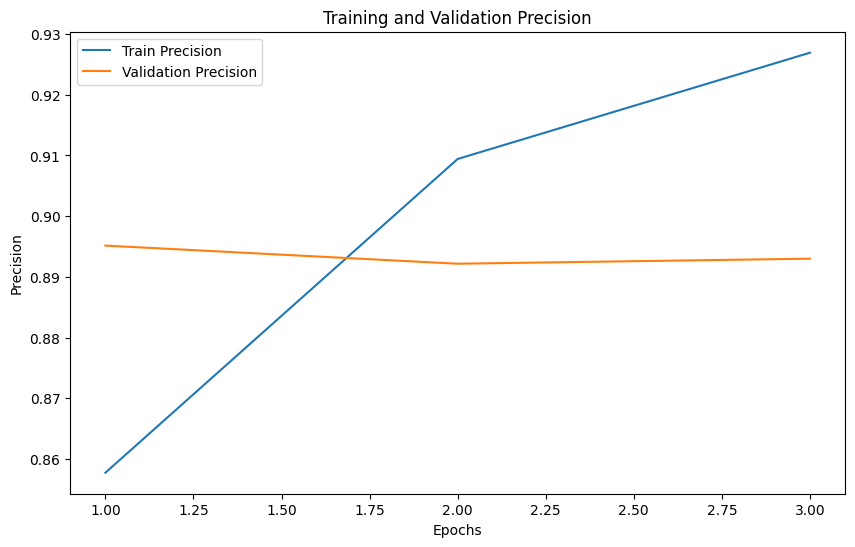

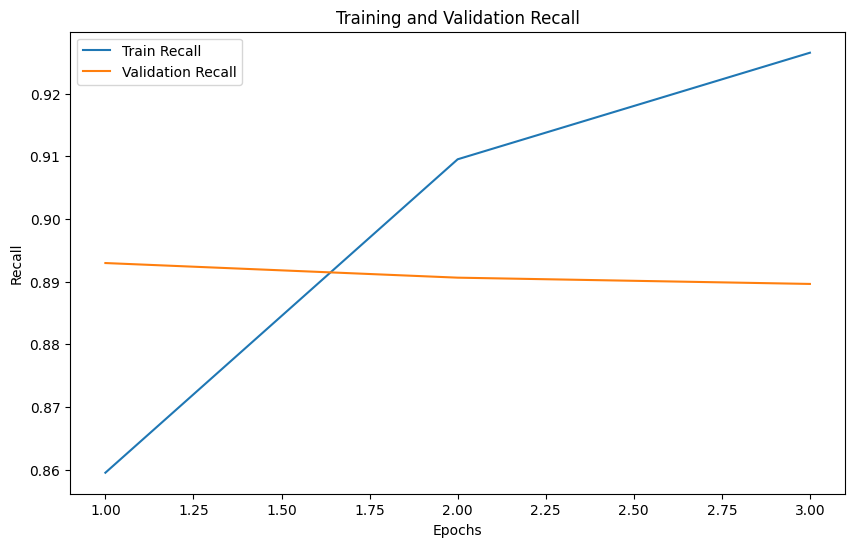

In [ ]:
# Plot training and validation metrics
epochs_range = range(1, len(bcl_acc_train) + 1)

# Plot Accuracy
plt.figure(figsize=(10, 6))
plt.plot(epochs_range, bcl_acc_train, label="Train Accuracy")
plt.plot(epochs_range, bcl_acc_val, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.savefig(f"/content/drive/My Drive/My Folder/Saved Models/Pretrained Models/BCL-HSD-30k/Figures and Reports/training_validation_accuracy_30k", bbox_inches="tight")
plt.show()

# Plot F1 Score
plt.figure(figsize=(10, 6))
plt.plot(epochs_range, bcl_f1_train, label="Train F1 Score")
plt.plot(epochs_range, bcl_f1_val, label="Validation F1 Score")
plt.xlabel("Epochs")
plt.ylabel("F1 Score")
plt.title("Training and Validation F1 Score")
plt.legend()
plt.savefig(f"/content/drive/My Drive/My Folder/Saved Models/Pretrained Models/BCL-HSD-30k/Figures and Reports/training_validation_f1_score_30k.png", bbox_inches="tight")
plt.show()

# Plot Precision
plt.figure(figsize=(10, 6))
plt.plot(epochs_range, bcl_pre_train, label="Train Precision")
plt.plot(epochs_range, bcl_pre_val, label="Validation Precision")
plt.xlabel("Epochs")
plt.ylabel("Precision")
plt.title("Training and Validation Precision")
plt.legend()
plt.savefig(f"/content/drive/My Drive/My Folder/Saved Models/Pretrained Models/BCL-HSD-30k/Figures and Reports/training_validation_precision_30k.png", bbox_inches="tight")
plt.show()

# Plot Recall
plt.figure(figsize=(10, 6))
plt.plot(epochs_range, bcl_rec_train, label="Train Recall")
plt.plot(epochs_range, bcl_rec_val, label="Validation Recall")
plt.xlabel("Epochs")
plt.ylabel("Recall")
plt.title("Training and Validation Recall")
plt.legend()
plt.savefig(f"/content/drive/My Drive/My Folder/Saved Models/Pretrained Models/BCL-HSD-30k/Figures and Reports/training_validation_recall_30k.png", bbox_inches="tight")
plt.show()

#Evaluate

In [ ]:
def evaluate_model(model, test_loader):
    model.eval()
    predictions, true_labels = [], []

    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            outputs = model(input_ids, attention_mask)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            predictions.extend(preds)
            true_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions, average="weighted")
    precision = precision_score(true_labels, predictions, average="weighted")
    recall = recall_score(true_labels, predictions, average="weighted")

    # Generate confusion matrix for test set
    conf_matrix = confusion_matrix(true_labels, predictions)
    # Generate classification report
    report = classification_report(true_labels, predictions, target_names=['Non-Hate', 'Hate'])

    print(f"Accuracy: {acc}, F1: {f1}, Precision: {precision}, Recall: {recall}")
    return conf_matrix, report

In [ ]:
# Evaluate the model
conf_matrix, report = evaluate_model(trained_model, test_loader)

Accuracy: 0.8956666666666667, F1: 0.8966347338132714, Precision: 0.8991202914704155, Recall: 0.8956666666666667


#Plot Confusion Matrix

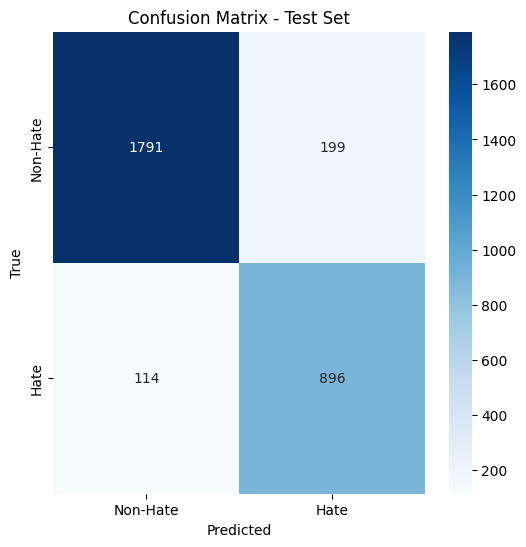

In [ ]:
# Plot confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Hate', 'Hate'], yticklabels=['Non-Hate', 'Hate'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Test Set')
plt.savefig(f"/content/drive/My Drive/My Folder/Saved Models/Pretrained Models/BCL-HSD-30k/Figures and Reports/confusion_matrix_test_set_30k.png", bbox_inches="tight")
plt.show()

In [ ]:
# Print classification report
print(report)
# Save the classification report as a text file
with open("/content/drive/My Drive/My Folder/Saved Models/Pretrained Models/BCL-HSD-30k/Figures and Reports/classification_report_test_set_30k.txt", "w") as f:
    f.write(report)

              precision    recall  f1-score   support

    Non-Hate       0.94      0.90      0.92      1990
        Hate       0.82      0.89      0.85      1010

    accuracy                           0.90      3000
   macro avg       0.88      0.89      0.89      3000
weighted avg       0.90      0.90      0.90      3000



#Saving the model in Huggingface

In [ ]:
! pip install huggingface_hub --q

In [ ]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    A token is already saved on your machine. Run `huggingface-cli whoami` to get more information or `huggingface-cli logout` if you want to log out.
    Setting a new token will erase the existing one.
    To log in, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) y
Token is valid (permission: fineG

In [ ]:
from huggingface_hub import hf_hub_download, snapshot_download
from huggingface_hub import login
from huggingface_hub import HfApi, HfFolder
from huggingface_hub.repocard import metadata_eval_result, metadata_save

model_save_path = "/content/drive/My Drive/My Folder/Saved Models/Pretrained Models/BCL-HSD-30k"

# Push the model to the hub using the HfApi
api = HfApi()
api.create_repo(repo_id="nadiaafsara/BCL-HSD-30k", exist_ok=True) # Create the repo if it doesn't exist
api.upload_folder(
    folder_path=model_save_path,
    repo_id="nadiaafsara/BCL-HSD-30k",
    repo_type="model",
    ignore_patterns=['.git'],
)

pytorch_model.bin:   0%|          | 0.00/442M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/nadiaafsara/BCL-HSD-30k/commit/6e6ed278773831b4f9e54795a3d51245e7f385d5', commit_message='Upload folder using huggingface_hub', commit_description='', oid='6e6ed278773831b4f9e54795a3d51245e7f385d5', pr_url=None, repo_url=RepoUrl('https://huggingface.co/nadiaafsara/BCL-HSD-30k', endpoint='https://huggingface.co', repo_type='model', repo_id='nadiaafsara/BCL-HSD-30k'), pr_revision=None, pr_num=None)

Load from huggingface

In [ ]:
model = BertCNNBiLSTM(bert_model_name="csebuetnlp/banglabert", num_classes=2)
# Load the model weights from the Hugging Face Hub
model.load_state_dict(torch.load(hf_hub_download(repo_id="nadiaafsara/BCL-HSD-30k", filename="pytorch_model.bin"), map_location=device))
tokenizer = AutoTokenizer.from_pretrained("nadiaafsara/BCL-HSD-30k")

pytorch_model.bin:   0%|          | 0.00/442M [00:00<?, ?B/s]

<ipython-input-128-c347818abb04>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(hf_hub_download(repo_id="nadiaafsara/BCL-HSD-30k", filenam

tokenizer_config.json:   0%|          | 0.00/1.33k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/528k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.03M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

#Save Model in Drive

Save Model

In [ ]:
# Save the trained model
model_save_path = "/content/drive/My Drive/My Folder/Saved Models/Pretrained Models/BCL-HSD-30k"

# Save model weights
torch.save(trained_model.state_dict(), f"{model_save_path}/pytorch_model.bin")

# Save tokenizer
tokenizer.save_pretrained(model_save_path)

# Save model config
config = {
    "model_type": "bert-cnn-bilstm",
    "bert_model_name": "csebuetnlp/banglabert",
    "num_labels": 2,
}
with open(f"{model_save_path}/config.json", "w") as f:
    json.dump(config, f)

Load Model

In [ ]:
# Specify the model save path
model_save_path = "/content/drive/My Drive/My Folder/Saved Models/Pretrained Models/BCL-HSD-30k"

# Load the configuration
with open(f"{model_save_path}/config.json", "r") as f:
    config = json.load(f)

# Reconstruct the model
model = BertCNNBiLSTM(
    bert_model_name=config["bert_model_name"],
    num_classes=config["num_labels"]
)

# Load the model weights
model.load_state_dict(torch.load(f"{model_save_path}/pytorch_model.bin", map_location=device))
model.to(device)
model.eval()

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_save_path)

<ipython-input-53-46a7e3c3d75f>:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"{model_save_path}/pytorch_model.bin", map_location=devic

#Dataset 73k

In [ ]:
# Load the dataset
df = pd.read_csv("hf://datasets/Sky1241/hsban_merge_73k/merged_dataset73k.csv")

In [ ]:
df.columns

Index(['text', 'label'], dtype='object')

Normalize datasest

In [ ]:
for i in range(100):
  print(df.text[i])

যত্তসব পাপন শালার ফাজলামী!!!!!
পাপন শালা রে রিমান্ডে নেওয়া দরকার
জিল্লুর রহমান স্যারের ছেলে এতো বড় জারজ হবে এটা একটা দেশের মানুষ কোনো দিন ও ভাবতে পারেনি।ধন্যবাদ তাহসিন ভাই।
শালা লুচ্চা দেখতে পাঠার মত দেখা যায়
তুই তো শালা গাজা খাইছচ।তুর মার হেডায় খেলবে সাকিব
এটা কুন দরনের কেলা ফাইজলামি তাস্কিন রে চর মারা দরকার
পাপন ভর মাদা চোদ পাপনে পদতেক চাই
দুরো সালার পুদ চুপথাক
কুত্তার বাছচা পাপন
বাল ছাল তর সাউয়া😡
তোর কপালে জুতা মারি শালার পুত
পাপনে পাগল হয়াছে
দেখেছো মাগি না হিজরা বোঝা যাচ্ছে না। দেখে মনে হচ্ছে হিজরা
হালার পু পাপন
শালায় এই কারণেই খেলায় ডাব্বা মারে😡😠
ব্ব
পাপন হালারে বেট থেকে জুতার মালা দিয়এই বের করে না কেনে ওর কারনে ভাল পিলিআর গুলো খেলা পারেনা
পাপন মাঘির পুতের পেটের মদ্দে দুর্নিতি ভরা
পাপনকে জুতার মালা দেয়া জরুর
আমি হলে তো জারসি পড়া লোকটাকে চুদেদিতাম
ইয়েছির আলী হালা খেলা জানেনা
কুত্তার বাচ্চা পাপন
পাপন মাগির পোলার এটা করছে
মাগির পুয়া
ক্রিকেট মনে হয় ওনার বাবার সম্পত্তি হালার ফু
বিসিবির সবকটাই চোরমাদারচোদ
কুকুরের চাচ্চা তদেক কি হয়চে নবীকে গারি দিয়াচে তদেক কিচু হয়নি। আর সাদারন একটা মানু

In [ ]:
df = df.dropna()  # Remove any rows with missing values
l = len(df.text)
n = Normalize()

for i in range (l):
    text = df.text[i]
    ct = n.normalize_text(text)
    if ct=='':
        df = df.drop([i])#Dropping empty row
    else:
        df.loc[i,'text'] = ct


In [ ]:
for i in range(100):
  print(df.text[i])

যত্তসব পাপন শালার ফাজলামী
পাপন শালা রে রিমান্ডে নেওয়া দরকার
জিল্লুর রহমান স্যারের ছেলে এতো বড় জারজ হবে এটা একটা দেশের মানুষ কোনো দিন ও ভাবতে পারেনিধন্যবাদ তাহসিন ভাই
শালা লুচ্চা দেখতে পাঠার মত দেখা যায়
তুই তো শালা গাজা খাইছচতুর মার হেডায় খেলবে সাকিব
এটা কুন দরনের কেলা ফাইজলামি তাস্কিন রে চর মারা দরকার
পাপন ভর মাদা চোদ পাপনে পদতেক চাই
দুরো সালার পুদ চুপথাক
কুত্তার বাছচা পাপন
বাল ছাল তর সাউয়া
তোর কপালে জুতা মারি শালার পুত
পাপনে পাগল হয়াছে
দেখেছো মাগি না হিজরা বোঝা যাচ্ছে না দেখে মনে হচ্ছে হিজরা
হালার পু পাপন
শালায় এই কারণেই খেলায় ডাব্বা মারে
ব্ব
পাপন হালারে বেট থেকে জুতার মালা দিয়এই বের করে না কেনে ওর কারনে ভাল পিলিআর গুলো খেলা পারেনা
পাপন মাঘির পুতের পেটের মদ্দে দুর্নিতি ভরা
পাপনকে জুতার মালা দেয়া জরুর
আমি হলে তো জারসি পড়া লোকটাকে চুদেদিতাম
ইয়েছির আলী হালা খেলা জানেনা
কুত্তার বাচ্চা পাপন
পাপন মাগির পোলার এটা করছে
মাগির পুয়া
ক্রিকেট মনে হয় ওনার বাবার সম্পত্তি হালার ফু
বিসিবির সবকটাই চোরমাদারচোদ
কুকুরের চাচ্চা তদেক কি হয়চে নবীকে গারি দিয়াচে তদেক কিচু হয়নি আর সাদারন একটা মানুষকে গারিদিয়েচ

In [ ]:
dataset = Dataset.from_pandas(df)

#Split Dataset

In [ ]:
dataset = dataset.train_test_split(test_size=0.2)
test_data = dataset["test"].train_test_split(test_size=0.5)
train_data = dataset["train"]
valid_data = test_data["train"]
test_data = test_data["test"]

In [ ]:
print(len(train_data))
print(len(valid_data))
print(len(test_data))

58905
7363
7364


#Train with Earlyl Stopping

In [ ]:
class EarlyStopping:
    def __init__(self, patience=patience, mode="max", delta=0.001):
        self.patience = patience
        self.mode = mode
        self.delta = delta
        self.best_metric = None
        self.counter = 0
        self.stop_training = False

    def __call__(self, current_metric):
        if self.best_metric is None or (
            self.mode == "min" and current_metric < self.best_metric - self.delta
        ) or (
            self.mode == "max" and current_metric > self.best_metric + self.delta
        ):
            self.best_metric = current_metric
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.stop_training = True

In [ ]:
def compute_metrics(predictions, labels):
    acc = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average="weighted")
    precision = precision_score(labels, predictions, average="weighted")
    recall = recall_score(labels, predictions, average="weighted")
    return acc, f1, precision, recall

#BCL-HSD

In [ ]:
bcl_acc_train = []
bcl_f1_train = []
bcl_pre_train = []
bcl_rec_train = []
bcl_acc_val = []
bcl_f1_val = []
bcl_pre_val = []
bcl_rec_val = []

In [ ]:
class BertCNNBiLSTM(nn.Module):
    def __init__(self, bert_model_name, num_classes):
        super(BertCNNBiLSTM, self).__init__()
        self.bert = AutoModel.from_pretrained(bert_model_name)
        self.cnn = nn.Conv1d(in_channels=768, out_channels=128, kernel_size=3, padding=1)
        self.lstm = nn.LSTM(input_size=128, hidden_size=64, num_layers=1, bidirectional=True, batch_first=True)
        self.fc = nn.Linear(64 * 2, num_classes)
        self.dropout = nn.Dropout(0.3)

    def forward(self, input_ids, attention_mask):
        bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        hidden_states = bert_output.last_hidden_state
        cnn_output = self.cnn(hidden_states.transpose(1, 2))
        lstm_output, _ = self.lstm(cnn_output.transpose(1, 2))
        pooled_output = lstm_output[:, -1, :]
        output = self.fc(self.dropout(pooled_output))
        return output

In [ ]:
# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained("csebuetnlp/banglabert")

tokenizer_config.json:   0%|          | 0.00/119 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/528k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

#Tokenization

In [ ]:
# Tokenize the dataset
def tokenize_data(samples):
    return tokenizer(
        samples["text"],
        truncation=True,
        padding="max_length",
        max_length=128
    )

In [ ]:
# Apply tokenization to the datasets
train_data = train_data.map(tokenize_data, batched=True)
valid_data = valid_data.map(tokenize_data, batched=True)
test_data = test_data.map(tokenize_data, batched=True)

Map:   0%|          | 0/58905 [00:00<?, ? examples/s]

Map:   0%|          | 0/7363 [00:00<?, ? examples/s]

Map:   0%|          | 0/7364 [00:00<?, ? examples/s]

In [ ]:
print(train_data.column_names)
print(valid_data.column_names)
print(test_data.column_names)

['text', 'label', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask']
['text', 'label', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask']
['text', 'label', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask']


In [ ]:
# Remove unnecessary columns
train_data.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
valid_data.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
test_data.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

#Data Loaders

In [ ]:
# Define DataLoader
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=batch_size)

#Initialize Model

In [ ]:
# Initialize the model, criterion, and optimizer
model = BertCNNBiLSTM("csebuetnlp/banglabert", num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=learning_rate)

/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


#Train Model

In [ ]:
def train_model_with_early_stopping_and_metrics(
    model, train_loader, valid_loader, criterion, optimizer, epochs=epochs, patience=patience
):
    early_stopping = EarlyStopping(patience=patience, mode="max")  # Monitoring validation accuracy
    best_model_state = None
    best_epoch = 0

    for epoch in range(epochs):
        # Training phase
        model.train()
        train_predictions, train_labels = [], []
        total_loss = 0

        for batch in train_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            # Collect predictions and labels
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            train_predictions.extend(preds)
            train_labels.extend(labels.cpu().numpy())

        train_acc, train_f1, train_precision, train_recall = compute_metrics(train_predictions, train_labels)
        bcl_acc_train.append(train_acc )
        bcl_f1_train.append(train_f1)
        bcl_pre_train.append(train_precision)
        bcl_rec_train.append(train_recall)
        print(
            f"Epoch {epoch + 1}/{epochs}, Training Loss: {total_loss / len(train_loader):.4f}, "
            f"Accuracy: {train_acc:.4f}, F1: {train_f1:.4f}, Precision: {train_precision:.4f}, Recall: {train_recall:.4f}"
        )

        # Validation phase
        model.eval()
        valid_predictions, valid_labels = [], []
        valid_loss = 0

        with torch.no_grad():
            for batch in valid_loader:
                input_ids = batch["input_ids"].to(device)
                attention_mask = batch["attention_mask"].to(device)
                labels = batch["label"].to(device)
                outputs = model(input_ids, attention_mask)
                loss = criterion(outputs, labels)
                valid_loss += loss.item()

                # Collect predictions and labels
                preds = torch.argmax(outputs, dim=1).cpu().numpy()
                valid_predictions.extend(preds)
                valid_labels.extend(labels.cpu().numpy())

        valid_acc, valid_f1, valid_precision, valid_recall = compute_metrics(valid_predictions, valid_labels)
        bcl_acc_val.append(valid_acc)
        bcl_f1_val.append(valid_f1)
        bcl_pre_val.append(valid_precision)
        bcl_rec_val.append(valid_recall)
        print(
            f"Epoch {epoch + 1}/{epochs}, Validation Loss: {valid_loss / len(valid_loader):.4f}, "
            f"Accuracy: {valid_acc:.4f}, F1: {valid_f1:.4f}, Precision: {valid_precision:.4f}, Recall: {valid_recall:.4f}"
        )

        # Early stopping check
        early_stopping(valid_acc)
        if early_stopping.stop_training:
            print(f"Early stopping triggered at epoch {epoch + 1}")
            break

        # Save the best model state
        if early_stopping.best_metric == valid_acc:
            best_model_state = model.state_dict()
            best_epoch = epoch + 1

    # Restore the best model state
    if best_model_state:
        model.load_state_dict(best_model_state)
        print(f"Loaded the best model from epoch {best_epoch}")

    return model

In [ ]:
# Train the model
trained_model = train_model_with_early_stopping_and_metrics(
    model, train_loader, valid_loader, criterion, optimizer, epochs=epochs, patience=patience
)

Epoch 1/10, Training Loss: 0.3415, Accuracy: 0.8566, F1: 0.8561, Precision: 0.8567, Recall: 0.8566
Epoch 1/10, Validation Loss: 0.2984, Accuracy: 0.8731, F1: 0.8735, Precision: 0.8767, Recall: 0.8731
Epoch 2/10, Training Loss: 0.2527, Accuracy: 0.8961, F1: 0.8962, Precision: 0.8965, Recall: 0.8961
Epoch 2/10, Validation Loss: 0.2753, Accuracy: 0.8836, F1: 0.8838, Precision: 0.8842, Recall: 0.8836
Epoch 3/10, Training Loss: 0.2028, Accuracy: 0.9186, F1: 0.9187, Precision: 0.9192, Recall: 0.9186
Epoch 3/10, Validation Loss: 0.2966, Accuracy: 0.8873, F1: 0.8874, Precision: 0.8876, Recall: 0.8873
Epoch 4/10, Training Loss: 0.1594, Accuracy: 0.9387, F1: 0.9388, Precision: 0.9393, Recall: 0.9387
Epoch 4/10, Validation Loss: 0.3323, Accuracy: 0.8668, F1: 0.8672, Precision: 0.8791, Recall: 0.8668
Epoch 5/10, Training Loss: 0.1272, Accuracy: 0.9511, F1: 0.9511, Precision: 0.9515, Recall: 0.9511
Epoch 5/10, Validation Loss: 0.3449, Accuracy: 0.8832, F1: 0.8836, Precision: 0.8878, Recall: 0.8832


#Plot the Training and Validation metrics

In [ ]:
os.makedirs("/content/drive/My Drive/My Folder/Saved Models/Pretrained Models/BCL-HSD-73k/Figures and Reports/", exist_ok=True)

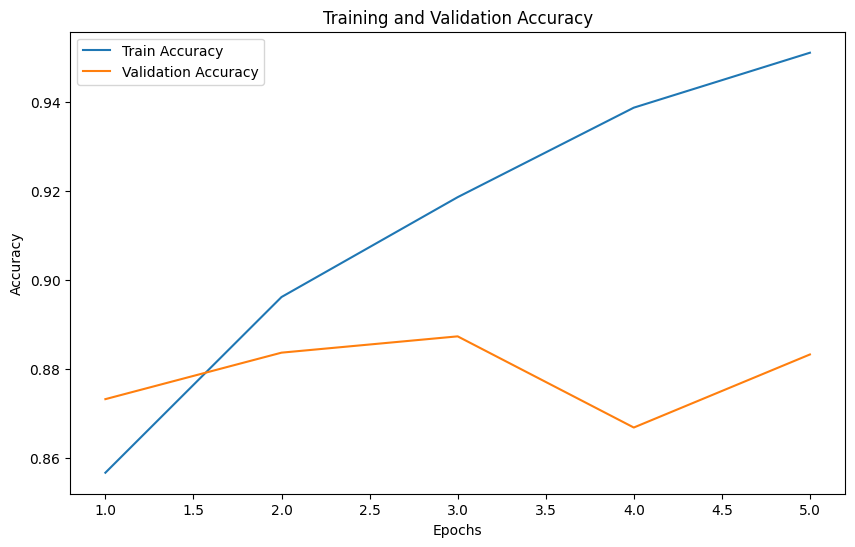

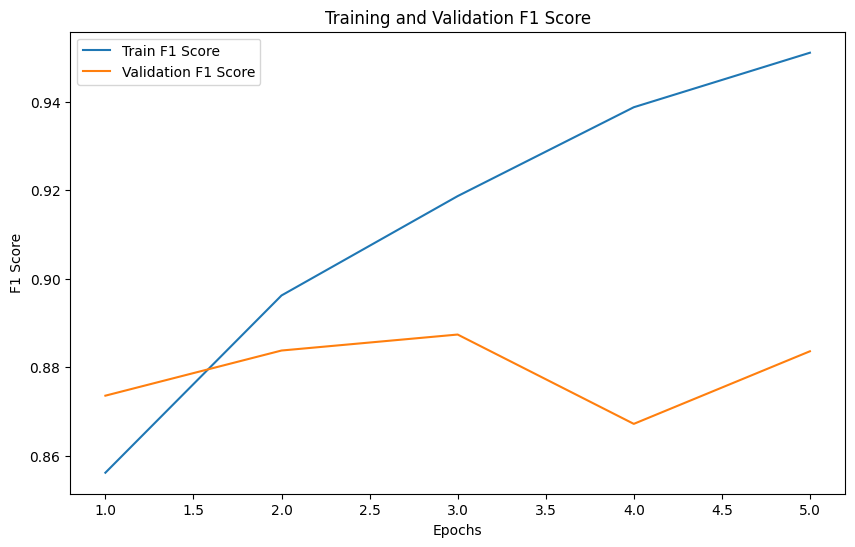

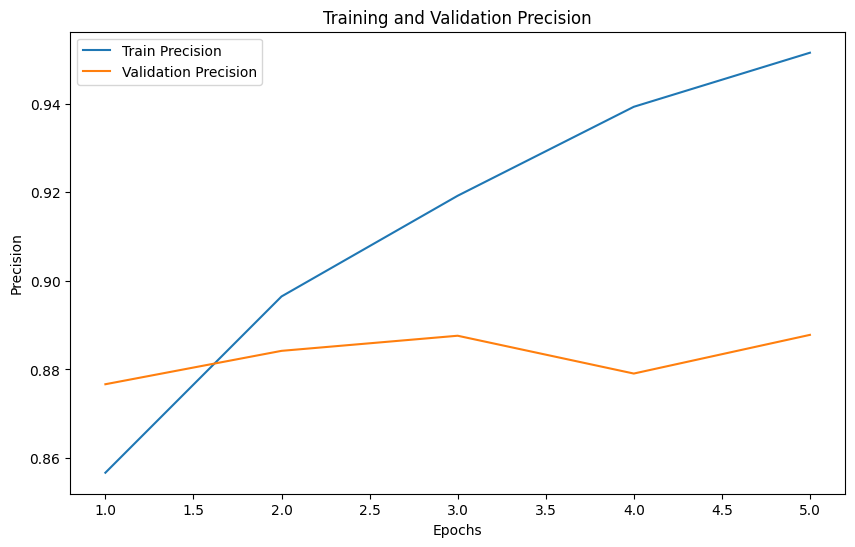

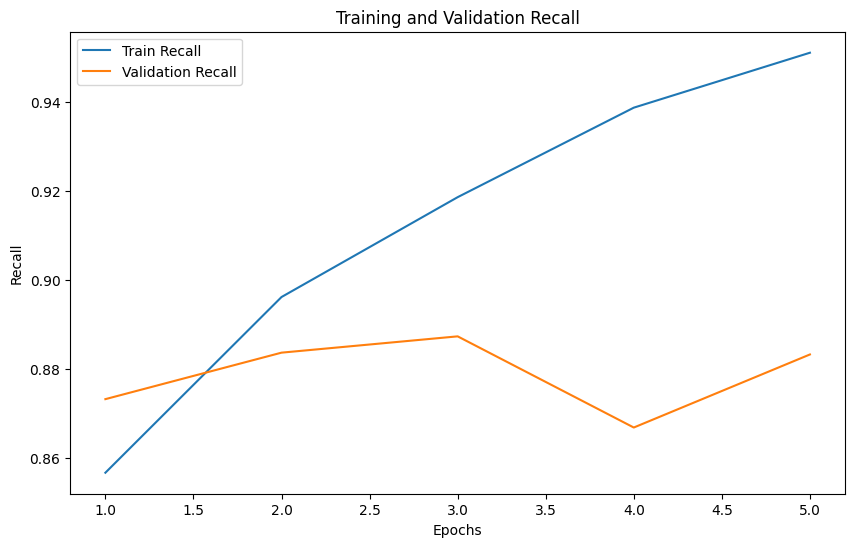

In [ ]:
# Plot training and validation metrics
epochs_range = range(1, len(bcl_acc_train) + 1)

# Plot Accuracy
plt.figure(figsize=(10, 6))
plt.plot(epochs_range, bcl_acc_train, label="Train Accuracy")
plt.plot(epochs_range, bcl_acc_val, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.savefig(f"/content/drive/My Drive/My Folder/Saved Models/Pretrained Models/BCL-HSD-73k/Figures and Reports/training_validation_accuracy_73k.png", bbox_inches="tight")
plt.show()

# Plot F1 Score
plt.figure(figsize=(10, 6))
plt.plot(epochs_range, bcl_f1_train, label="Train F1 Score")
plt.plot(epochs_range, bcl_f1_val, label="Validation F1 Score")
plt.xlabel("Epochs")
plt.ylabel("F1 Score")
plt.title("Training and Validation F1 Score")
plt.legend()
plt.savefig(f"/content/drive/My Drive/My Folder/Saved Models/Pretrained Models/BCL-HSD-73k/Figures and Reports/training_validation_f1_score_73k.png", bbox_inches="tight")
plt.show()

# Plot Precision
plt.figure(figsize=(10, 6))
plt.plot(epochs_range, bcl_pre_train, label="Train Precision")
plt.plot(epochs_range, bcl_pre_val, label="Validation Precision")
plt.xlabel("Epochs")
plt.ylabel("Precision")
plt.title("Training and Validation Precision")
plt.legend()
plt.savefig(f"/content/drive/My Drive/My Folder/Saved Models/Pretrained Models/BCL-HSD-73k/Figures and Reports/training_validation_precision_73k.png", bbox_inches="tight")
plt.show()

# Plot Recall
plt.figure(figsize=(10, 6))
plt.plot(epochs_range, bcl_rec_train, label="Train Recall")
plt.plot(epochs_range, bcl_rec_val, label="Validation Recall")
plt.xlabel("Epochs")
plt.ylabel("Recall")
plt.title("Training and Validation Recall")
plt.legend()
plt.savefig(f"/content/drive/My Drive/My Folder/Saved Models/Pretrained Models/BCL-HSD-73k/Figures and Reports/training_validation_recall_73k.png", bbox_inches="tight")
plt.show()

#EVALUATE

In [ ]:
def evaluate_model(model, test_loader):
    model.eval()
    predictions, true_labels = [], []

    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            outputs = model(input_ids, attention_mask)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            predictions.extend(preds)
            true_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions, average="weighted")
    precision = precision_score(true_labels, predictions, average="weighted")
    recall = recall_score(true_labels, predictions, average="weighted")

    # Generate confusion matrix for test set
    conf_matrix = confusion_matrix(true_labels, predictions)
    # Generate classification report
    report = classification_report(true_labels, predictions, target_names=['Non-Hate', 'Hate'])

    print(f"Accuracy: {acc}, F1: {f1}, Precision: {precision}, Recall: {recall}")
    return conf_matrix, report

In [ ]:
# Evaluate the model
conf_matrix, report = evaluate_model(trained_model, test_loader)

Accuracy: 0.8901412275936991, F1: 0.8904308446067613, Precision: 0.893935912993662, Recall: 0.8901412275936991


#Plot Confusion matrix

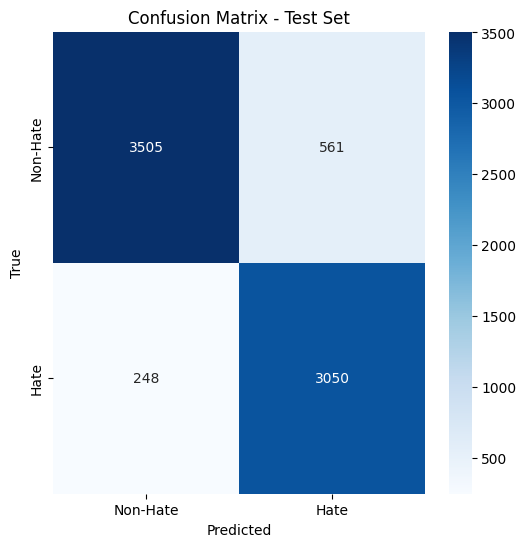

In [ ]:
# Plot confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Hate', 'Hate'], yticklabels=['Non-Hate', 'Hate'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Test Set')
plt.savefig(f"/content/drive/My Drive/My Folder/Saved Models/Pretrained Models/BCL-HSD-73k/Figures and Reports/confusion_matrix_test_set_73k.png", bbox_inches="tight")
plt.show()

In [ ]:
# Print classification report
print(report)
# Save the classification report as a text file
with open("/content/drive/My Drive/My Folder/Saved Models/Pretrained Models/BCL-HSD-73k/Figures and Reports/classification_report_test_set_73k.txt", "w") as f:
    f.write(report)

              precision    recall  f1-score   support

    Non-Hate       0.93      0.86      0.90      4066
        Hate       0.84      0.92      0.88      3298

    accuracy                           0.89      7364
   macro avg       0.89      0.89      0.89      7364
weighted avg       0.89      0.89      0.89      7364



#Save Model in Huggingface

In [ ]:
! pip install huggingface_hub --q

In [ ]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    A token is already saved on your machine. Run `huggingface-cli whoami` to get more information or `huggingface-cli logout` if you want to log out.
    Setting a new token will erase the existing one.
    To log in, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) n
Token is valid (permission: fineG

In [ ]:
from huggingface_hub import hf_hub_download, snapshot_download
from huggingface_hub import login
from huggingface_hub import HfApi, HfFolder
from huggingface_hub.repocard import metadata_eval_result, metadata_save

model_save_path = "/content/drive/My Drive/My Folder/Saved Models/Pretrained Models/BCL-HSD-73k"

# Push the model to the hub using the HfApi
api = HfApi()
api.create_repo(repo_id="nadiaafsara/BCL-HSD-73k", exist_ok=True) # Create the repo if it doesn't exist
api.upload_folder(
    folder_path=model_save_path,
    repo_id="nadiaafsara/BCL-HSD-73k",
    repo_type="model",
    ignore_patterns=['.git'],
)

pytorch_model.bin:   0%|          | 0.00/442M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/nadiaafsara/BCL-HSD-73k/commit/c66b46a247f60a542aa177897db74c6246f30cd7', commit_message='Upload folder using huggingface_hub', commit_description='', oid='c66b46a247f60a542aa177897db74c6246f30cd7', pr_url=None, repo_url=RepoUrl('https://huggingface.co/nadiaafsara/BCL-HSD-73k', endpoint='https://huggingface.co', repo_type='model', repo_id='nadiaafsara/BCL-HSD-73k'), pr_revision=None, pr_num=None)

Load from huggingface

In [ ]:
model = BertCNNBiLSTM(bert_model_name="csebuetnlp/banglabert", num_classes=2)
# Load the model weights from the Hugging Face Hub
model.load_state_dict(torch.load(hf_hub_download(repo_id="nadiaafsara/BCL-HSD-73k", filename="pytorch_model.bin"), map_location=device))
tokenizer = AutoTokenizer.from_pretrained("nadiaafsara/BCL-HSD-73k")

pytorch_model.bin:   0%|          | 0.00/442M [00:00<?, ?B/s]

<ipython-input-48-73b19735cefe>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(hf_hub_download(repo_id="nadiaafsara/BCL-HSD-73k", filename

tokenizer_config.json:   0%|          | 0.00/1.33k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/528k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.03M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

#Save in drive

In [ ]:
# Save the trained model
model_save_path = "/content/drive/My Drive/My Folder/Saved Models/Pretrained Models/BCL-HSD-73k"

# Save model weights
torch.save(trained_model.state_dict(), f"{model_save_path}/pytorch_model.bin")

# Save tokenizer
tokenizer.save_pretrained(model_save_path)

# Save model config
config = {
    "model_type": "bert-cnn-bilstm",
    "bert_model_name": "csebuetnlp/banglabert",
    "num_labels": 2,
}
with open(f"{model_save_path}/config.json", "w") as f:
    json.dump(config, f)

Load

In [ ]:
# Specify the model save path
model_save_path = "/content/drive/My Drive/My Folder/Saved Models/Pretrained Models/BCL-HSD-73k"

# Load the configuration
with open(f"{model_save_path}/config.json", "r") as f:
    config = json.load(f)

# Reconstruct the model
model = BertCNNBiLSTM(
    bert_model_name=config["bert_model_name"],
    num_classes=config["num_labels"]
)

# Load the model weights
model.load_state_dict(torch.load(f"{model_save_path}/pytorch_model.bin", map_location=device))
model.to(device)
model.eval()

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_save_path)

<ipython-input-50-4b09ccd8f811>:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"{model_save_path}/pytorch_model.bin", map_location=devic

#BanglaHateBert

#30k Dataset

In [ ]:
# Load the dataset
df = pd.read_csv("hf://datasets/nadiaafsara/Bhs-Kag/BSH_Kag_30k.csv")

In [ ]:
df.columns
df = df.rename(columns={'sentence': 'text', 'hate': 'label'})  # Adjust columns as necessary
df.columns

Index(['text', 'label', 'category'], dtype='object')

In [ ]:
df = df.dropna()  # Remove any rows with missing values
l = len(df.text)
n = Normalize()

for i in range (l):
    text = df.text[i]
    ct = n.normalize_text(text)
    if ct=='':
        df = df.drop([i])#Dropping empty row
    else:
        df.loc[i,'text'] = ct

dataset = Dataset.from_pandas(df)

Split Dataset

In [ ]:
dataset = dataset.train_test_split(test_size=0.2)
test_data = dataset["test"].train_test_split(test_size=0.5)
train_data = dataset["train"]
valid_data = test_data["train"]
test_data = test_data["test"]

In [ ]:
print(len(train_data))
print(len(valid_data))
print(len(test_data))

23994
2999
3000


Train with Early Stopping

In [ ]:
class EarlyStopping:
    def __init__(self, patience=patience, mode="max", delta=0.001):
        self.patience = patience
        self.mode = mode
        self.delta = delta
        self.best_metric = None
        self.counter = 0
        self.stop_training = False

    def __call__(self, current_metric):
        if self.best_metric is None or (
            self.mode == "min" and current_metric < self.best_metric - self.delta
        ) or (
            self.mode == "max" and current_metric > self.best_metric + self.delta
        ):
            self.best_metric = current_metric
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.stop_training = True

In [ ]:
def compute_metrics(predictions, labels):
    acc = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average="weighted")
    precision = precision_score(labels, predictions, average="weighted")
    recall = recall_score(labels, predictions, average="weighted")
    return acc, f1, precision, recall

In [ ]:
bhb_acc_train = []
bhb_f1_train = []
bhb_pre_train = []
bhb_rec_train = []
bhb_acc_val = []
bhb_f1_val = []
bhb_pre_val = []
bhb_rec_val = []

Load Model

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("saroarj/BanglaHateBert")
model = AutoModelForSequenceClassification.from_pretrained("saroarj/BanglaHateBert")
model.to(device)

tokenizer_config.json:   0%|          | 0.00/430 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/528k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/793 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/443M [00:00<?, ?B/s]

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at saroarj/BanglaHateBert and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight', 'embeddings.LayerNorm.bias', 'embeddings.LayerNorm.weight', 'embeddings.position_embeddings.weight', 'embeddings.token_type_embeddings.weight', 'embeddings.word_embeddings.weight', 'encoder.layer.0.attention.output.LayerNorm.bias', 'encoder.layer.0.attention.output.LayerNorm.weight', 'encoder.layer.0.attention.output.dense.bias', 'encoder.layer.0.attention.output.dense.weight', 'encoder.layer.0.attention.self.key.bias', 'encoder.layer.0.attention.self.key.weight', 'encoder.layer.0.attention.self.query.bias', 'encoder.layer.0.attention.self.query.weight', 'encoder.layer.0.attention.self.value.bias', 'encoder.layer.0.attention.self.value.weight', 'encoder.layer.0.intermediate.dense.bias', 'encoder.layer.0.intermediate.dense.weight',

ElectraForSequenceClassification(
  (electra): ElectraModel(
    (embeddings): ElectraEmbeddings(
      (word_embeddings): Embedding(32000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): ElectraEncoder(
      (layer): ModuleList(
        (0-11): 12 x ElectraLayer(
          (attention): ElectraAttention(
            (self): ElectraSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ElectraSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): L

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=learning_rate)

/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Tokenization

In [ ]:
# Tokenize the dataset
def tokenize_data(samples):
    return tokenizer(
        samples["text"],
        truncation=True,
        padding="max_length",
        max_length=128
    )

In [ ]:
# Apply tokenization to the datasets
train_data = train_data.map(tokenize_data, batched=True)
valid_data = valid_data.map(tokenize_data, batched=True)
test_data = test_data.map(tokenize_data, batched=True)

Map:   0%|          | 0/23994 [00:00<?, ? examples/s]

Map:   0%|          | 0/2999 [00:00<?, ? examples/s]

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

In [ ]:
print(train_data.column_names)
print(valid_data.column_names)
print(test_data.column_names)

['text', 'label', 'category', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask']
['text', 'label', 'category', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask']
['text', 'label', 'category', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask']


In [ ]:
# Remove unnecessary columns
train_data.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
valid_data.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
test_data.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

Data Loader

In [ ]:
# Define DataLoader
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=batch_size)

Train Model

In [ ]:
def train_model_with_early_stopping_and_metrics(model, train_loader, valid_loader, criterion, optimizer, epochs=10, patience=3):
    early_stopping = EarlyStopping(patience=patience, mode="max")
    best_model_state = None
    best_epoch = 0

    for epoch in range(epochs):
        # Training phase
        model.train()
        train_predictions, train_labels = [], []
        total_loss = 0

        for batch in train_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits

            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            preds = torch.argmax(logits, dim=1).cpu().numpy()
            train_predictions.extend(preds)
            train_labels.extend(labels.cpu().numpy())

        train_acc, train_f1, train_precision, train_recall = compute_metrics(train_predictions, train_labels)
        print(
            f"Epoch {epoch + 1}/{epochs}, Training Loss: {total_loss / len(train_loader):.4f}, "
            f"Accuracy: {train_acc:.4f}, F1: {train_f1:.4f}, Precision: {train_precision:.4f}, Recall: {train_recall:.4f}"
        )
        bhb_acc_train.append(train_acc)
        bhb_f1_train.append(train_f1)
        bhb_pre_train.append(train_precision)
        bhb_rec_train.append(train_recall)

        # Validation phase
        model.eval()
        valid_predictions, valid_labels = [], []
        valid_loss = 0

        with torch.no_grad():
            for batch in valid_loader:
                input_ids = batch["input_ids"].to(device)
                attention_mask = batch["attention_mask"].to(device)
                labels = batch["label"].to(device)
                outputs = model(input_ids, attention_mask=attention_mask)
                logits = outputs.logits
                loss = criterion(logits, labels)
                valid_loss += loss.item()

                preds = torch.argmax(logits, dim=1).cpu().numpy()
                valid_predictions.extend(preds)
                valid_labels.extend(labels.cpu().numpy())

        valid_acc, valid_f1, valid_precision, valid_recall = compute_metrics(valid_predictions, valid_labels)
        print(
            f"Epoch {epoch + 1}/{epochs}, Validation Loss: {valid_loss / len(valid_loader):.4f}, "
            f"Accuracy: {valid_acc:.4f}, F1: {valid_f1:.4f}, Precision: {valid_precision:.4f}, Recall: {valid_recall:.4f}"
        )
        bhb_acc_val.append(valid_acc)
        bhb_f1_val.append(valid_f1)
        bhb_pre_val.append(valid_precision)
        bhb_rec_val.append(valid_recall)

        early_stopping(valid_acc)
        if early_stopping.stop_training:
            print(f"Early stopping triggered at epoch {epoch + 1}")
            break

        if early_stopping.best_metric == valid_acc:
            best_model_state = model.state_dict()
            best_epoch = epoch + 1

    if best_model_state:
        model.load_state_dict(best_model_state)
        print(f"Loaded the best model from epoch {best_epoch}")

    return model

In [ ]:
# Train the model
trained_model = train_model_with_early_stopping_and_metrics(
    model, train_loader, valid_loader, criterion, optimizer, epochs=epochs, patience=patience
)

Epoch 1/10, Training Loss: 0.4292, Accuracy: 0.8056, F1: 0.7954, Precision: 0.8043, Recall: 0.8056
Epoch 1/10, Validation Loss: 0.3140, Accuracy: 0.8793, F1: 0.8798, Precision: 0.8805, Recall: 0.8793
Epoch 2/10, Training Loss: 0.2846, Accuracy: 0.8862, F1: 0.8856, Precision: 0.8853, Recall: 0.8862
Epoch 2/10, Validation Loss: 0.2857, Accuracy: 0.8840, F1: 0.8826, Precision: 0.8828, Recall: 0.8840
Epoch 3/10, Training Loss: 0.2484, Accuracy: 0.9010, F1: 0.9008, Precision: 0.9007, Recall: 0.9010
Epoch 3/10, Validation Loss: 0.2734, Accuracy: 0.8913, F1: 0.8905, Precision: 0.8904, Recall: 0.8913
Epoch 4/10, Training Loss: 0.2206, Accuracy: 0.9128, F1: 0.9128, Precision: 0.9127, Recall: 0.9128
Epoch 4/10, Validation Loss: 0.2919, Accuracy: 0.8796, F1: 0.8764, Precision: 0.8800, Recall: 0.8796
Epoch 5/10, Training Loss: 0.1891, Accuracy: 0.9244, F1: 0.9245, Precision: 0.9245, Recall: 0.9244
Epoch 5/10, Validation Loss: 0.2975, Accuracy: 0.8863, F1: 0.8867, Precision: 0.8874, Recall: 0.8863


Plot Training and Validation Metrics



In [ ]:
os.makedirs("/content/drive/My Drive/My Folder/Saved Models/Pretrained Models/BanglaHateBert-30k/Figures and Reports/", exist_ok=True)

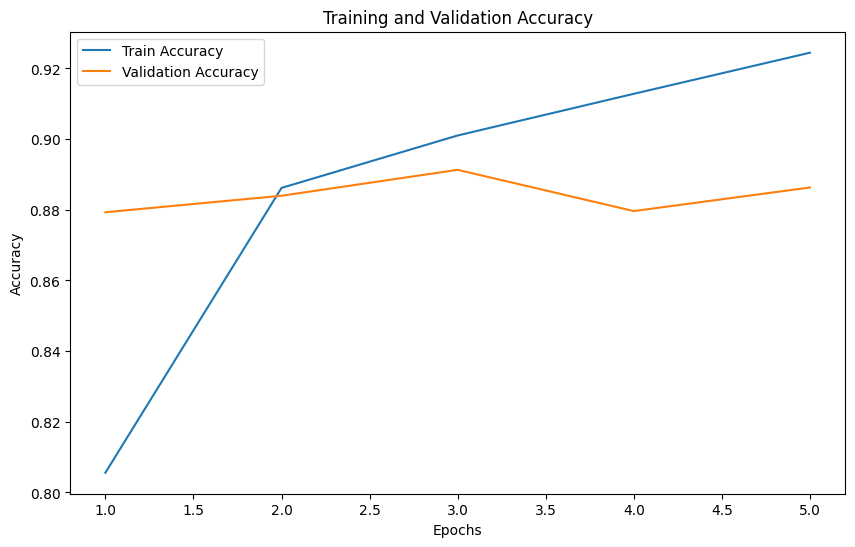

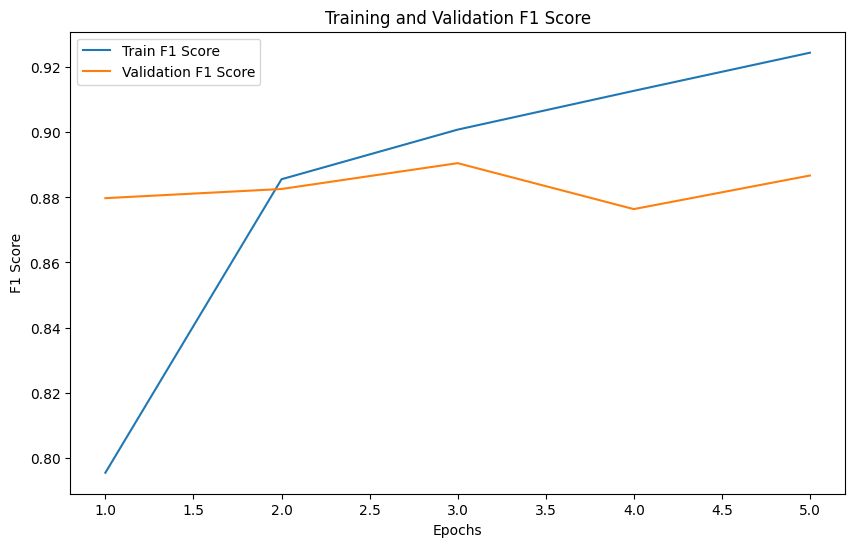

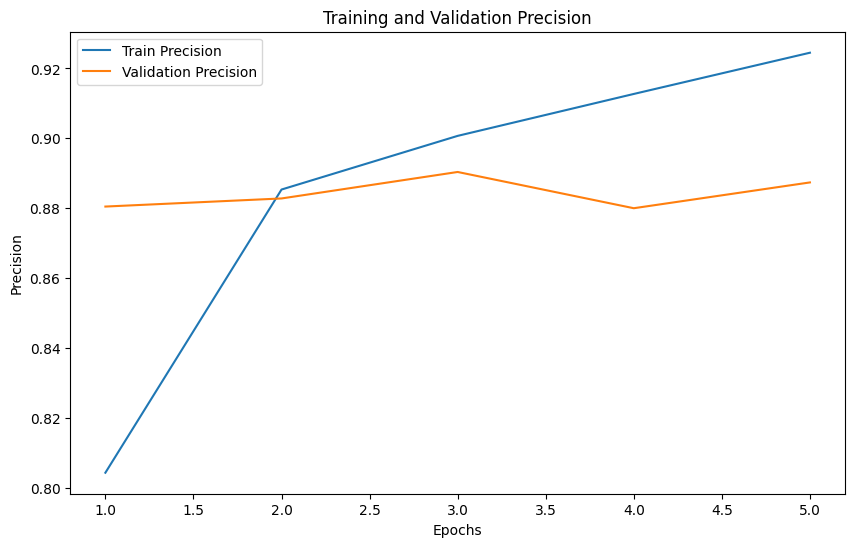

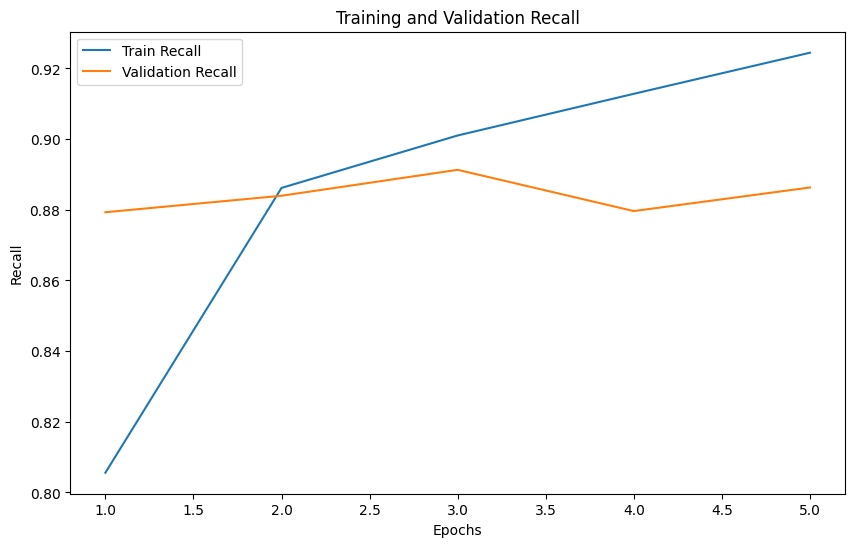

In [ ]:
# Plot training and validation metrics
epochs_range = range(1, len(bhb_acc_train) + 1)

# Plot Accuracy
plt.figure(figsize=(10, 6))
plt.plot(epochs_range, bhb_acc_train, label="Train Accuracy")
plt.plot(epochs_range, bhb_acc_val, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.savefig(f"/content/drive/My Drive/My Folder/Saved Models/Pretrained Models/BanglaHateBert-30k/Figures and Reports/training_validation_accuracy_bhb_30k.png", bbox_inches="tight")
plt.show()

# Plot F1 Score
plt.figure(figsize=(10, 6))
plt.plot(epochs_range, bhb_f1_train, label="Train F1 Score")
plt.plot(epochs_range, bhb_f1_val, label="Validation F1 Score")
plt.xlabel("Epochs")
plt.ylabel("F1 Score")
plt.title("Training and Validation F1 Score")
plt.legend()
plt.savefig(f"/content/drive/My Drive/My Folder/Saved Models/Pretrained Models/BanglaHateBert-30k/Figures and Reports/training_validation_f1_score_bhb_30k.png", bbox_inches="tight")
plt.show()

# Plot Precision
plt.figure(figsize=(10, 6))
plt.plot(epochs_range, bhb_pre_train, label="Train Precision")
plt.plot(epochs_range, bhb_pre_val, label="Validation Precision")
plt.xlabel("Epochs")
plt.ylabel("Precision")
plt.title("Training and Validation Precision")
plt.legend()
plt.savefig(f"/content/drive/My Drive/My Folder/Saved Models/Pretrained Models/BanglaHateBert-30k/Figures and Reports/training_validation_precision_bhb_30k.png", bbox_inches="tight")
plt.show()

# Plot Recall
plt.figure(figsize=(10, 6))
plt.plot(epochs_range, bhb_rec_train, label="Train Recall")
plt.plot(epochs_range, bhb_rec_val, label="Validation Recall")
plt.xlabel("Epochs")
plt.ylabel("Recall")
plt.title("Training and Validation Recall")
plt.legend()
plt.savefig(f"/content/drive/My Drive/My Folder/Saved Models/Pretrained Models/BanglaHateBert-30k/Figures and Reports/training_validation_recall_bhb_30k.png", bbox_inches="tight")
plt.show()

Evaluate

In [ ]:
def evaluate_model(model, test_loader):
    model.eval()
    predictions, true_labels = [], []

    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            outputs = model(input_ids, attention_mask)
            logits = outputs.logits

            preds = torch.argmax(logits, dim=1).cpu().numpy()
            predictions.extend(preds)
            true_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions, average="weighted")
    precision = precision_score(true_labels, predictions, average="weighted")
    recall = recall_score(true_labels, predictions, average="weighted")

    # Generate confusion matrix for test set
    conf_matrix = confusion_matrix(true_labels, predictions)
    # Generate classification report
    report = classification_report(true_labels, predictions, target_names=['Non-Hate', 'Hate'])

    print(f"Accuracy: {acc}, F1: {f1}, Precision: {precision}, Recall: {recall}")

    return conf_matrix, report

In [ ]:
# Evaluate the model
conf_matrix, report = evaluate_model(trained_model, test_loader)

Accuracy: 0.887, F1: 0.8872216166128892, Precision: 0.8875043956043955, Recall: 0.887


Plot Confusion matrix

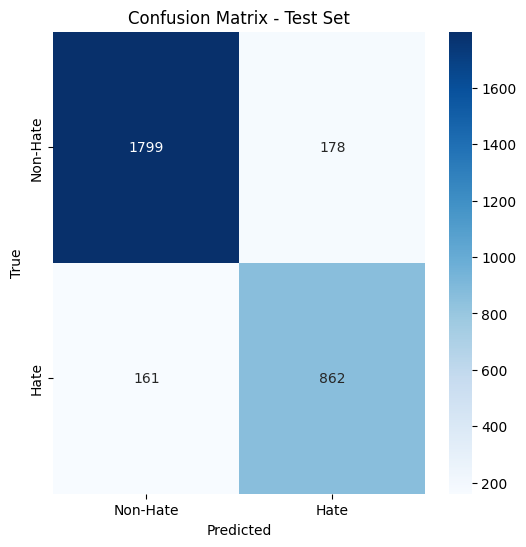

In [ ]:
# Plot confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Hate', 'Hate'], yticklabels=['Non-Hate', 'Hate'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Test Set')
plt.savefig(f"/content/drive/My Drive/My Folder/Saved Models/Pretrained Models/BanglaHateBert-30k/Figures and Reports/confusion_matrix_test_set_bhb_30k.png", bbox_inches="tight")
plt.show()

In [ ]:
# Print classification report
print(report)
# Save the classification report as a text file
with open("/content/drive/My Drive/My Folder/Saved Models/Pretrained Models/BanglaHateBert-30k/Figures and Reports/classification_report_test_set_bhb_30k.txt", "w") as f:
    f.write(report)

              precision    recall  f1-score   support

    Non-Hate       0.92      0.91      0.91      1977
        Hate       0.83      0.84      0.84      1023

    accuracy                           0.89      3000
   macro avg       0.87      0.88      0.87      3000
weighted avg       0.89      0.89      0.89      3000



#Save Model in Drive

In [ ]:
# Save the trained model
model_save_path = "/content/drive/My Drive/My Folder/Saved Models/Pretrained Models/BanglaHateBert-30k"

# Save model weights
torch.save(trained_model.state_dict(), f"{model_save_path}/pytorch_model.bin")

# Save tokenizer
tokenizer.save_pretrained(model_save_path)

# Save model config
config = {
    "model_type": "Bangla-hate-bert",
    "bert_model_name": "saroarj/BanglaHateBert",
    "num_labels": 2,
}
with open(f"{model_save_path}/config.json", "w") as f:
    json.dump(config, f)

Load model

In [ ]:
# Specify the model save path
model_save_path = "/content/drive/My Drive/My Folder/Saved Models/Pretrained Models/BanglaHateBert-30k"

# Load the configuration
with open(f"{model_save_path}/config.json", "r") as f:
    config = json.load(f)

# Load the model weights
model.load_state_dict(torch.load(f"{model_save_path}/pytorch_model.bin", map_location=device))
model.to(device)
model.eval()

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_save_path)

<ipython-input-37-b29a31a77c8f>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"{model_save_path}/pytorch_model.bin", map_location=device

#73K dataset

In [ ]:
bhb_acc_train = []
bhb_f1_train = []
bhb_pre_train = []
bhb_rec_train = []
bhb_acc_val = []
bhb_f1_val = []
bhb_pre_val = []
bhb_rec_val = []

In [ ]:
# Load the dataset
df = pd.read_csv("hf://datasets/Sky1241/hsban_merge_73k/merged_dataset73k.csv")

In [ ]:
df = df.dropna()
l = len(df.text)
n = Normalize()

for i in range (l):
    text = df.text[i]
    ct = n.normalize_text(text)
    if ct=='':
        df = df.drop([i])
    else:
        df.loc[i,'text'] = ct

dataset = Dataset.from_pandas(df)

Splikt Dataset

In [ ]:
dataset = dataset.train_test_split(test_size=0.2)
test_data = dataset["test"].train_test_split(test_size=0.5)
train_data = dataset["train"]
valid_data = test_data["train"]
test_data = test_data["test"]

In [ ]:
print(len(train_data))
print(len(valid_data))
print(len(test_data))

58905
7363
7364


Train with Early Stopping

In [ ]:
class EarlyStopping:
    def __init__(self, patience=patience, mode="max", delta=0.001):
        self.patience = patience
        self.mode = mode
        self.delta = delta
        self.best_metric = None
        self.counter = 0
        self.stop_training = False

    def __call__(self, current_metric):
        if self.best_metric is None or (
            self.mode == "min" and current_metric < self.best_metric - self.delta
        ) or (
            self.mode == "max" and current_metric > self.best_metric + self.delta
        ):
            self.best_metric = current_metric
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.stop_training = True

In [ ]:
def compute_metrics(predictions, labels):
    acc = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average="weighted")
    precision = precision_score(labels, predictions, average="weighted")
    recall = recall_score(labels, predictions, average="weighted")
    return acc, f1, precision, recall

Load Model

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("saroarj/BanglaHateBert")
model = AutoModelForSequenceClassification.from_pretrained("saroarj/BanglaHateBert")
model.to(device)

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at saroarj/BanglaHateBert and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight', 'embeddings.LayerNorm.bias', 'embeddings.LayerNorm.weight', 'embeddings.position_embeddings.weight', 'embeddings.token_type_embeddings.weight', 'embeddings.word_embeddings.weight', 'encoder.layer.0.attention.output.LayerNorm.bias', 'encoder.layer.0.attention.output.LayerNorm.weight', 'encoder.layer.0.attention.output.dense.bias', 'encoder.layer.0.attention.output.dense.weight', 'encoder.layer.0.attention.self.key.bias', 'encoder.layer.0.attention.self.key.weight', 'encoder.layer.0.attention.self.query.bias', 'encoder.layer.0.attention.self.query.weight', 'encoder.layer.0.attention.self.value.bias', 'encoder.layer.0.attention.self.value.weight', 'encoder.layer.0.intermediate.dense.bias', 'encoder.layer.0.intermediate.dense.weight',

ElectraForSequenceClassification(
  (electra): ElectraModel(
    (embeddings): ElectraEmbeddings(
      (word_embeddings): Embedding(32000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): ElectraEncoder(
      (layer): ModuleList(
        (0-11): 12 x ElectraLayer(
          (attention): ElectraAttention(
            (self): ElectraSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ElectraSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): L

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=learning_rate)

/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Tokenization

In [ ]:
# Tokenize the dataset
def tokenize_data(samples):
    return tokenizer(
        samples["text"],
        truncation=True,
        padding="max_length",
        max_length=128
    )

In [ ]:
# Apply tokenization to the datasets
train_data = train_data.map(tokenize_data, batched=True)
valid_data = valid_data.map(tokenize_data, batched=True)
test_data = test_data.map(tokenize_data, batched=True)

Map:   0%|          | 0/58905 [00:00<?, ? examples/s]

Map:   0%|          | 0/7363 [00:00<?, ? examples/s]

Map:   0%|          | 0/7364 [00:00<?, ? examples/s]

In [ ]:
print(train_data.column_names)
print(valid_data.column_names)
print(test_data.column_names)

['text', 'label', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask']
['text', 'label', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask']
['text', 'label', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask']


In [ ]:
# Remove unnecessary columns
train_data.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
valid_data.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
test_data.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

In [ ]:
# Define DataLoader
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=batch_size)

Train Model

In [ ]:
def train_model_with_early_stopping_and_metrics(model, train_loader, valid_loader, criterion, optimizer, epochs=10, patience=3):
    early_stopping = EarlyStopping(patience=patience, mode="max")
    best_model_state = None
    best_epoch = 0

    for epoch in range(epochs):
        # Training phase
        model.train()
        train_predictions, train_labels = [], []
        total_loss = 0

        for batch in train_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits

            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            preds = torch.argmax(logits, dim=1).cpu().numpy()
            train_predictions.extend(preds)
            train_labels.extend(labels.cpu().numpy())

        train_acc, train_f1, train_precision, train_recall = compute_metrics(train_predictions, train_labels)
        print(
            f"Epoch {epoch + 1}/{epochs}, Training Loss: {total_loss / len(train_loader):.4f}, "
            f"Accuracy: {train_acc:.4f}, F1: {train_f1:.4f}, Precision: {train_precision:.4f}, Recall: {train_recall:.4f}"
        )
        bhb_acc_train.append(train_acc)
        bhb_f1_train.append(train_f1)
        bhb_pre_train.append(train_precision)
        bhb_rec_train.append(train_recall)

        # Validation phase
        model.eval()
        valid_predictions, valid_labels = [], []
        valid_loss = 0

        with torch.no_grad():
            for batch in valid_loader:
                input_ids = batch["input_ids"].to(device)
                attention_mask = batch["attention_mask"].to(device)
                labels = batch["label"].to(device)
                outputs = model(input_ids, attention_mask=attention_mask)
                logits = outputs.logits
                loss = criterion(logits, labels)
                valid_loss += loss.item()

                preds = torch.argmax(logits, dim=1).cpu().numpy()
                valid_predictions.extend(preds)
                valid_labels.extend(labels.cpu().numpy())

        valid_acc, valid_f1, valid_precision, valid_recall = compute_metrics(valid_predictions, valid_labels)
        print(
            f"Epoch {epoch + 1}/{epochs}, Validation Loss: {valid_loss / len(valid_loader):.4f}, "
            f"Accuracy: {valid_acc:.4f}, F1: {valid_f1:.4f}, Precision: {valid_precision:.4f}, Recall: {valid_recall:.4f}"
        )
        bhb_acc_val.append(valid_acc)
        bhb_f1_val.append(valid_f1)
        bhb_pre_val.append(valid_precision)
        bhb_rec_val.append(valid_recall)

        early_stopping(valid_acc)
        if early_stopping.stop_training:
            print(f"Early stopping triggered at epoch {epoch + 1}")
            break

        if early_stopping.best_metric == valid_acc:
            best_model_state = model.state_dict()
            best_epoch = epoch + 1

    if best_model_state:
        model.load_state_dict(best_model_state)
        print(f"Loaded the best model from epoch {best_epoch}")

    return model

In [ ]:
# Train the model
trained_model = train_model_with_early_stopping_and_metrics(
    model, train_loader, valid_loader, criterion, optimizer, epochs=epochs, patience=patience
)

Epoch 1/10, Training Loss: 0.4147, Accuracy: 0.8002, F1: 0.7984, Precision: 0.8014, Recall: 0.8002
Epoch 1/10, Validation Loss: 0.3220, Accuracy: 0.8600, F1: 0.8596, Precision: 0.8599, Recall: 0.8600
Epoch 2/10, Training Loss: 0.3037, Accuracy: 0.8719, F1: 0.8718, Precision: 0.8717, Recall: 0.8719
Epoch 2/10, Validation Loss: 0.3047, Accuracy: 0.8712, F1: 0.8715, Precision: 0.8729, Recall: 0.8712
Epoch 3/10, Training Loss: 0.2724, Accuracy: 0.8844, F1: 0.8844, Precision: 0.8843, Recall: 0.8844
Epoch 3/10, Validation Loss: 0.3074, Accuracy: 0.8673, F1: 0.8675, Precision: 0.8679, Recall: 0.8673
Epoch 4/10, Training Loss: 0.2431, Accuracy: 0.8986, F1: 0.8986, Precision: 0.8986, Recall: 0.8986
Epoch 4/10, Validation Loss: 0.3544, Accuracy: 0.8708, F1: 0.8702, Precision: 0.8715, Recall: 0.8708
Early stopping triggered at epoch 4
Loaded the best model from epoch 2


Plot

In [ ]:
os.makedirs("/content/drive/My Drive/My Folder/Saved Models/Pretrained Models/BanglaHateBert-73k/Figures and Reports/", exist_ok=True)

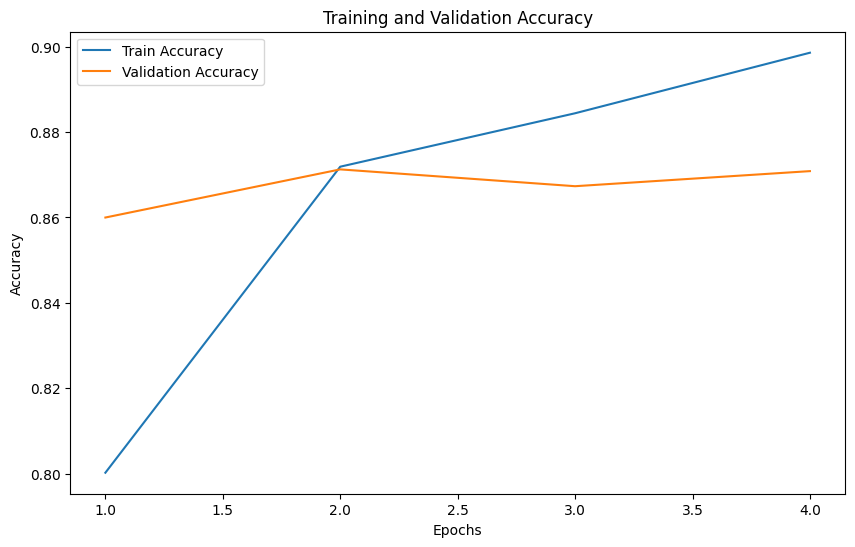

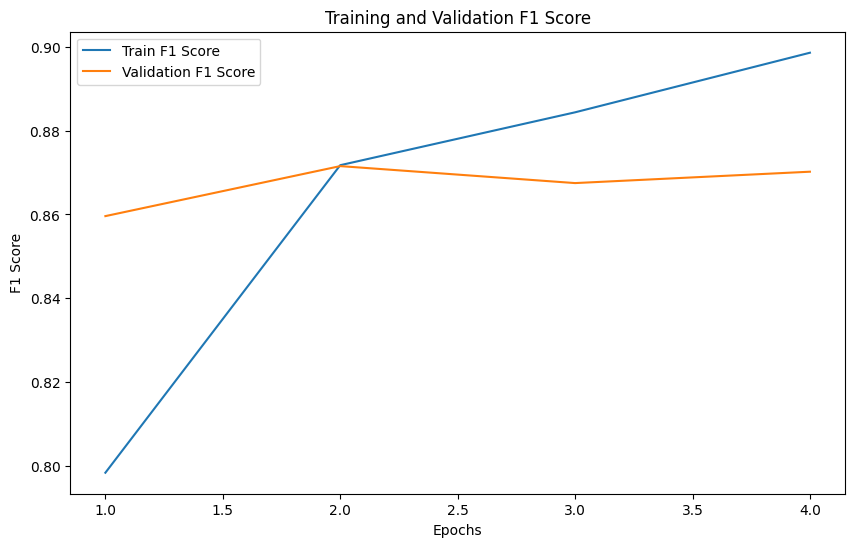

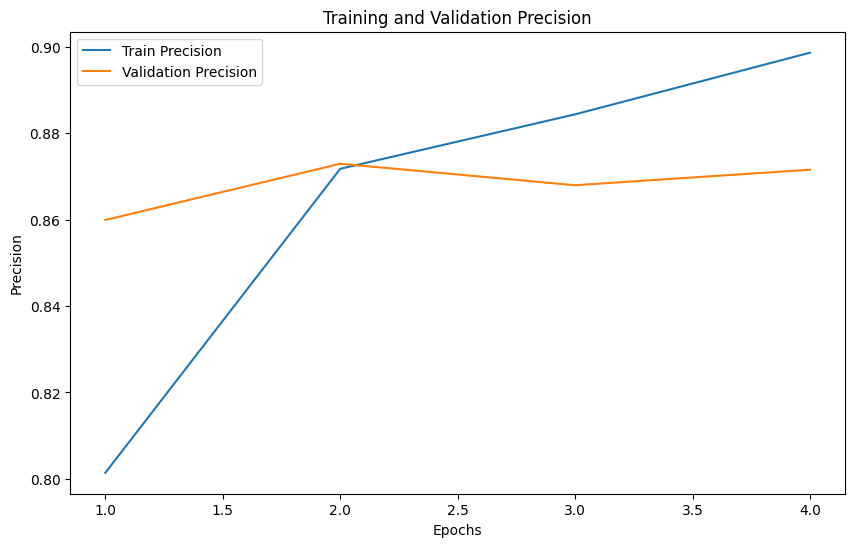

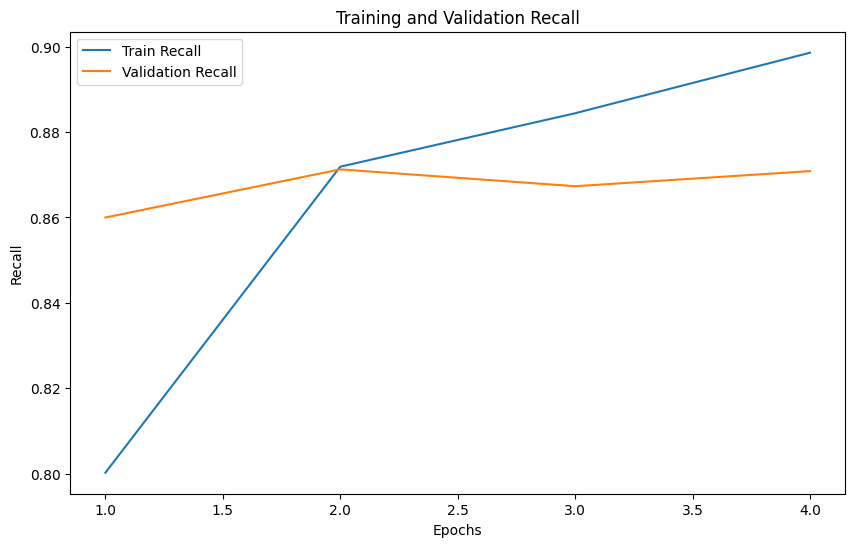

In [ ]:
# Plot training and validation metrics
epochs_range = range(1, len(bhb_acc_train) + 1)

# Plot Accuracy
plt.figure(figsize=(10, 6))
plt.plot(epochs_range, bhb_acc_train, label="Train Accuracy")
plt.plot(epochs_range, bhb_acc_val, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.savefig(f"/content/drive/My Drive/My Folder/Saved Models/Pretrained Models/BanglaHateBert-73k/Figures and Reports/training_validation_accuracy_bhb_73k.png", bbox_inches="tight")
plt.show()

# Plot F1 Score
plt.figure(figsize=(10, 6))
plt.plot(epochs_range, bhb_f1_train, label="Train F1 Score")
plt.plot(epochs_range, bhb_f1_val, label="Validation F1 Score")
plt.xlabel("Epochs")
plt.ylabel("F1 Score")
plt.title("Training and Validation F1 Score")
plt.legend()
plt.savefig(f"/content/drive/My Drive/My Folder/Saved Models/Pretrained Models/BanglaHateBert-73k/Figures and Reports/training_validation_f1_score_bhb_73k.png", bbox_inches="tight")
plt.show()

# Plot Precision
plt.figure(figsize=(10, 6))
plt.plot(epochs_range, bhb_pre_train, label="Train Precision")
plt.plot(epochs_range, bhb_pre_val, label="Validation Precision")
plt.xlabel("Epochs")
plt.ylabel("Precision")
plt.title("Training and Validation Precision")
plt.legend()
plt.savefig(f"/content/drive/My Drive/My Folder/Saved Models/Pretrained Models/BanglaHateBert-73k/Figures and Reports/training_validation_precision_bhb_73k.png", bbox_inches="tight")
plt.show()

# Plot Recall
plt.figure(figsize=(10, 6))
plt.plot(epochs_range, bhb_rec_train, label="Train Recall")
plt.plot(epochs_range, bhb_rec_val, label="Validation Recall")
plt.xlabel("Epochs")
plt.ylabel("Recall")
plt.title("Training and Validation Recall")
plt.legend()
plt.savefig(f"/content/drive/My Drive/My Folder/Saved Models/Pretrained Models/BanglaHateBert-73k/Figures and Reports/training_validation_recall_bhb_73k.png", bbox_inches="tight")
plt.show()

Evaluate

In [ ]:
def evaluate_model(model, test_loader):
    model.eval()
    predictions, true_labels = [], []

    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            outputs = model(input_ids, attention_mask)
            logits = outputs.logits

            preds = torch.argmax(logits, dim=1).cpu().numpy()
            predictions.extend(preds)
            true_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions, average="weighted")
    precision = precision_score(true_labels, predictions, average="weighted")
    recall = recall_score(true_labels, predictions, average="weighted")

    # Generate confusion matrix for test set
    conf_matrix = confusion_matrix(true_labels, predictions)
    # Generate classification report
    report = classification_report(true_labels, predictions, target_names=['Non-Hate', 'Hate'])

    print(f"Accuracy: {acc}, F1: {f1}, Precision: {precision}, Recall: {recall}")

    return conf_matrix, report

In [ ]:
# Evaluate the model
conf_matrix, report = evaluate_model(trained_model, test_loader)

Accuracy: 0.8711298207495927, F1: 0.8704745838264191, Precision: 0.8719953782836375, Recall: 0.8711298207495927


Test

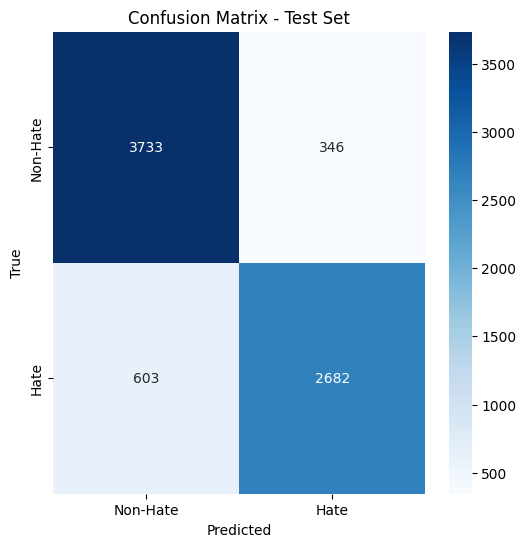

In [ ]:
# Plot confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Hate', 'Hate'], yticklabels=['Non-Hate', 'Hate'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Test Set')
plt.savefig(f"/content/drive/My Drive/My Folder/Saved Models/Pretrained Models/BanglaHateBert-73k/Figures and Reports/confusion_matrix_test_set_bhb_73k.png", bbox_inches="tight")
plt.show()

In [ ]:
# Print classification report
print(report)
# Save the classification report as a text file
with open("/content/drive/My Drive/My Folder/Saved Models/Pretrained Models/BanglaHateBert-73k/Figures and Reports/classification_report_test_set_bhb_73k.txt", "w") as f:
    f.write(report)

              precision    recall  f1-score   support

    Non-Hate       0.86      0.92      0.89      4079
        Hate       0.89      0.82      0.85      3285

    accuracy                           0.87      7364
   macro avg       0.87      0.87      0.87      7364
weighted avg       0.87      0.87      0.87      7364



Save Model in Drive

In [ ]:
# Save the trained model
model_save_path = "/content/drive/My Drive/My Folder/Saved Models/Pretrained Models/BanglaHateBert-73k"

# Save model weights
torch.save(trained_model.state_dict(), f"{model_save_path}/pytorch_model.bin")

# Save tokenizer
tokenizer.save_pretrained(model_save_path)

# Save model config
config = {
    "model_type": "Bangla-hate-bert",
    "bert_model_name": "saroarj/BanglaHateBert",
    "num_labels": 2,
}
with open(f"{model_save_path}/config.json", "w") as f:
    json.dump(config, f)

Load Model

In [ ]:
# Specify the model save path
model_save_path = "/content/drive/My Drive/My Folder/Saved Models/Pretrained Models/BanglaHateBert-73k"

# Load the configuration
with open(f"{model_save_path}/config.json", "r") as f:
    config = json.load(f)

# Load the model weights
model.load_state_dict(torch.load(f"{model_save_path}/pytorch_model.bin", map_location=device))
model.to(device)
model.eval()

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_save_path)

<ipython-input-61-77c980c5dfb1>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"{model_save_path}/pytorch_model.bin", map_location=device

#BCL-HSD-MT

#30k Dataset

In [ ]:
bcl_acc_train = []
bcl_f1_train = []
bcl_pre_train = []
bcl_rec_train = []
bcl_acc_val = []
bcl_f1_val = []
bcl_pre_val = []
bcl_rec_val = []

In [ ]:
# Load the dataset
df = pd.read_csv("hf://datasets/nadiaafsara/Bhs-Kag/BSH_Kag_30k.csv")

In [ ]:
df.columns
df = df.rename(columns={'sentence': 'text', 'hate': 'label'})
df.columns

Index(['text', 'label', 'category'], dtype='object')

In [ ]:
df = df.dropna()
l = len(df.text)
n = Normalize()

for i in range (l):
    text = df.text[i]
    ct = n.normalize_text(text)
    if ct=='':
        df = df.drop([i])
    else:
        df.loc[i,'text'] = ct

dataset = Dataset.from_pandas(df)

Split dataset

In [ ]:
dataset = dataset.train_test_split(test_size=0.2)
test_data = dataset["test"].train_test_split(test_size=0.5)
train_data = dataset["train"]
valid_data = test_data["train"]
test_data = test_data["test"]

In [ ]:
print(len(train_data))
print(len(valid_data))
print(len(test_data))

23994
2999
3000


Early stopping

In [ ]:
class EarlyStopping:
    def __init__(self, patience=patience, mode="max", delta=0.001):
        self.patience = patience
        self.mode = mode
        self.delta = delta
        self.best_metric = None
        self.counter = 0
        self.stop_training = False

    def __call__(self, current_metric):
        if self.best_metric is None or (
            self.mode == "min" and current_metric < self.best_metric - self.delta
        ) or (
            self.mode == "max" and current_metric > self.best_metric + self.delta
        ):
            self.best_metric = current_metric
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.stop_training = True

In [ ]:
def compute_metrics(predictions, labels):
    acc = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average="weighted")
    precision = precision_score(labels, predictions, average="weighted")
    recall = recall_score(labels, predictions, average="weighted")
    return acc, f1, precision, recall

In [ ]:
class BertCNNBiLSTM(nn.Module):
    def __init__(self, bert_model_name, num_classes):
        super(BertCNNBiLSTM, self).__init__()
        self.bert = AutoModel.from_pretrained(bert_model_name)
        self.cnn = nn.Conv1d(in_channels=768, out_channels=128, kernel_size=3, padding=1)
        self.lstm = nn.LSTM(input_size=128, hidden_size=64, num_layers=1, bidirectional=True, batch_first=True)
        self.fc = nn.Linear(64 * 2, num_classes)
        self.dropout = nn.Dropout(0.3)

    def forward(self, input_ids, attention_mask):
        bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        hidden_states = bert_output.last_hidden_state
        cnn_output = self.cnn(hidden_states.transpose(1, 2))
        lstm_output, _ = self.lstm(cnn_output.transpose(1, 2))
        pooled_output = lstm_output[:, -1, :]
        output = self.fc(self.dropout(pooled_output))
        return output

Load Model

In [ ]:
# Load the model structure
bert_model_name = "csebuetnlp/banglabert"  # Pre-trained BERT model for tokenization
num_classes = 2

# Initialize the custom model
model = BertCNNBiLSTM(bert_model_name=bert_model_name, num_classes=num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=learning_rate)

# Download the model weights from Hugging Face Hub
weights_path = hf_hub_download(repo_id="nadiaafsara/BCL-HSD-73k", filename="pytorch_model.bin")

# Load the model weights into the model
model.load_state_dict(torch.load(weights_path, map_location=device))

# Move the model to the appropriate device (CPU or GPU)
model.to(device)

# Load the tokenizer for model from Hugging Face Hub
tokenizer = AutoTokenizer.from_pretrained("nadiaafsara/BCL-HSD-73k")

config.json:   0%|          | 0.00/586 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/443M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/442M [00:00<?, ?B/s]

<ipython-input-71-d78f761efa4c>:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(weights_path, map_location=device))


tokenizer_config.json:   0%|          | 0.00/1.33k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/528k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.03M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

Tokenization

In [ ]:
# Tokenize the dataset
def tokenize_data(samples):
    return tokenizer(
        samples["text"],
        truncation=True,
        padding="max_length",
        max_length=128
    )

In [ ]:
# Apply tokenization to the datasets
train_data = train_data.map(tokenize_data, batched=True)
valid_data = valid_data.map(tokenize_data, batched=True)
test_data = test_data.map(tokenize_data, batched=True)

Map:   0%|          | 0/23994 [00:00<?, ? examples/s]

Map:   0%|          | 0/2999 [00:00<?, ? examples/s]

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

In [ ]:
print(train_data.column_names)
print(valid_data.column_names)
print(test_data.column_names)

['text', 'label', 'category', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask']
['text', 'label', 'category', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask']
['text', 'label', 'category', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask']


In [ ]:
# Remove unnecessary columns
train_data.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
valid_data.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
test_data.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

In [ ]:
# Define DataLoader
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=batch_size)

Train Model

In [ ]:
def train_model_with_early_stopping_and_metrics(
    model, train_loader, valid_loader, criterion, optimizer, epochs=epochs, patience=patience
):
    early_stopping = EarlyStopping(patience=patience, mode="max")  # Monitoring validation accuracy
    best_model_state = None
    best_epoch = 0

    for epoch in range(epochs):
        # Training phase
        model.train()
        train_predictions, train_labels = [], []
        total_loss = 0

        for batch in train_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            # Collect predictions and labels
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            train_predictions.extend(preds)
            train_labels.extend(labels.cpu().numpy())

        train_acc, train_f1, train_precision, train_recall = compute_metrics(train_predictions, train_labels)
        bcl_acc_train.append(train_acc )
        bcl_f1_train.append(train_f1)
        bcl_pre_train.append(train_precision)
        bcl_rec_train.append(train_recall)
        print(
            f"Epoch {epoch + 1}/{epochs}, Training Loss: {total_loss / len(train_loader):.4f}, "
            f"Accuracy: {train_acc:.4f}, F1: {train_f1:.4f}, Precision: {train_precision:.4f}, Recall: {train_recall:.4f}"
        )

        # Validation phase
        model.eval()
        valid_predictions, valid_labels = [], []
        valid_loss = 0

        with torch.no_grad():
            for batch in valid_loader:
                input_ids = batch["input_ids"].to(device)
                attention_mask = batch["attention_mask"].to(device)
                labels = batch["label"].to(device)
                outputs = model(input_ids, attention_mask)
                loss = criterion(outputs, labels)
                valid_loss += loss.item()

                # Collect predictions and labels
                preds = torch.argmax(outputs, dim=1).cpu().numpy()
                valid_predictions.extend(preds)
                valid_labels.extend(labels.cpu().numpy())

        valid_acc, valid_f1, valid_precision, valid_recall = compute_metrics(valid_predictions, valid_labels)
        bcl_acc_val.append(valid_acc)
        bcl_f1_val.append(valid_f1)
        bcl_pre_val.append(valid_precision)
        bcl_rec_val.append(valid_recall)
        print(
            f"Epoch {epoch + 1}/{epochs}, Validation Loss: {valid_loss / len(valid_loader):.4f}, "
            f"Accuracy: {valid_acc:.4f}, F1: {valid_f1:.4f}, Precision: {valid_precision:.4f}, Recall: {valid_recall:.4f}"
        )

        # Early stopping check
        early_stopping(valid_acc)
        if early_stopping.stop_training:
            print(f"Early stopping triggered at epoch {epoch + 1}")
            break

        # Save the best model state
        if early_stopping.best_metric == valid_acc:
            best_model_state = model.state_dict()
            best_epoch = epoch + 1

    # Restore the best model state
    if best_model_state:
        model.load_state_dict(best_model_state)
        print(f"Loaded the best model from epoch {best_epoch}")

    return model

In [ ]:
# Train the model
trained_model = train_model_with_early_stopping_and_metrics(
    model, train_loader, valid_loader, criterion, optimizer, epochs=epochs, patience=patience
)

Epoch 1/10, Training Loss: 0.1250, Accuracy: 0.9546, F1: 0.9547, Precision: 0.9548, Recall: 0.9546
Epoch 1/10, Validation Loss: 0.1141, Accuracy: 0.9623, F1: 0.9625, Precision: 0.9629, Recall: 0.9623
Epoch 2/10, Training Loss: 0.0853, Accuracy: 0.9700, F1: 0.9700, Precision: 0.9701, Recall: 0.9700
Epoch 2/10, Validation Loss: 0.1532, Accuracy: 0.9466, F1: 0.9473, Precision: 0.9502, Recall: 0.9466
Epoch 3/10, Training Loss: 0.0606, Accuracy: 0.9794, F1: 0.9794, Precision: 0.9794, Recall: 0.9794
Epoch 3/10, Validation Loss: 0.1371, Accuracy: 0.9553, F1: 0.9555, Precision: 0.9560, Recall: 0.9553
Early stopping triggered at epoch 3
Loaded the best model from epoch 1


Plot

In [ ]:
os.makedirs("/content/drive/My Drive/My Folder/Saved Models/Pretrained Models/BCL-HSD-73kPT-30k/Figures and Reports", exist_ok=True)

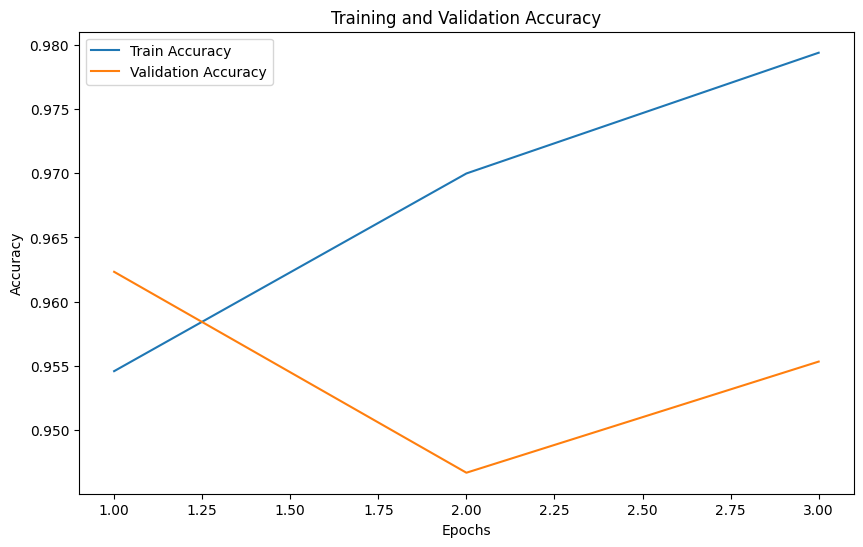

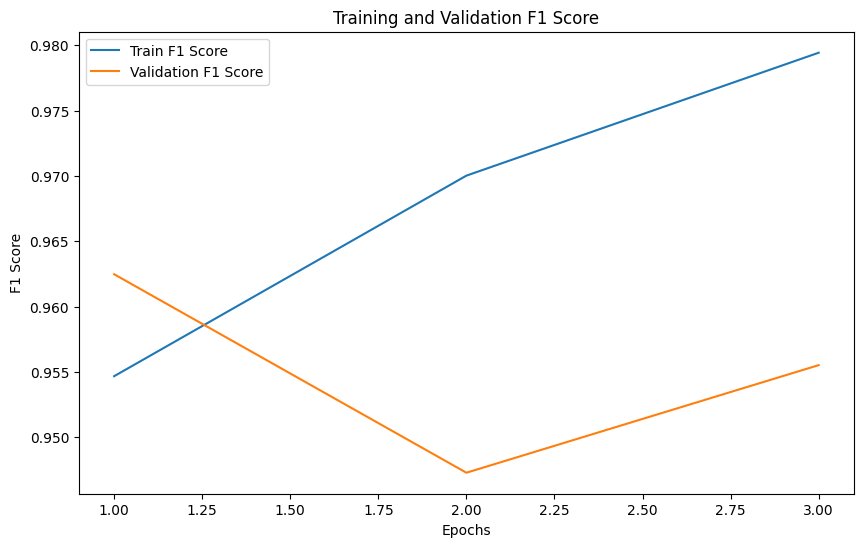

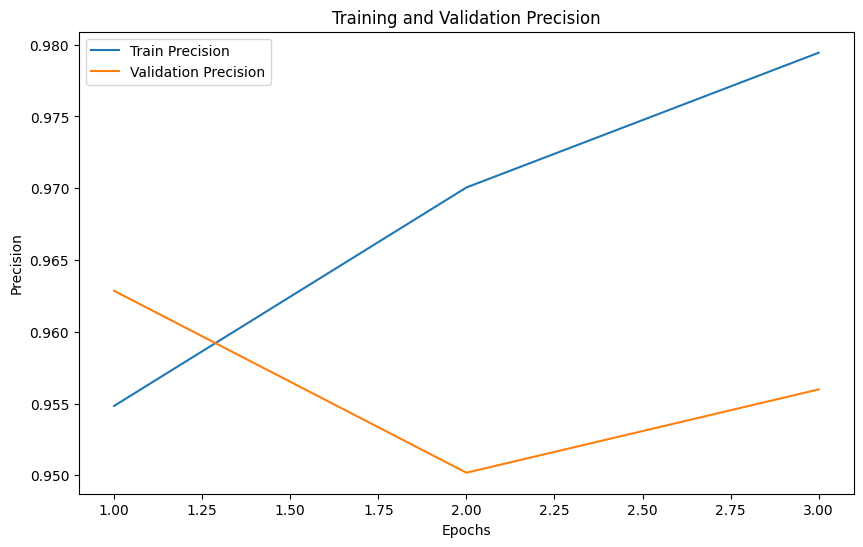

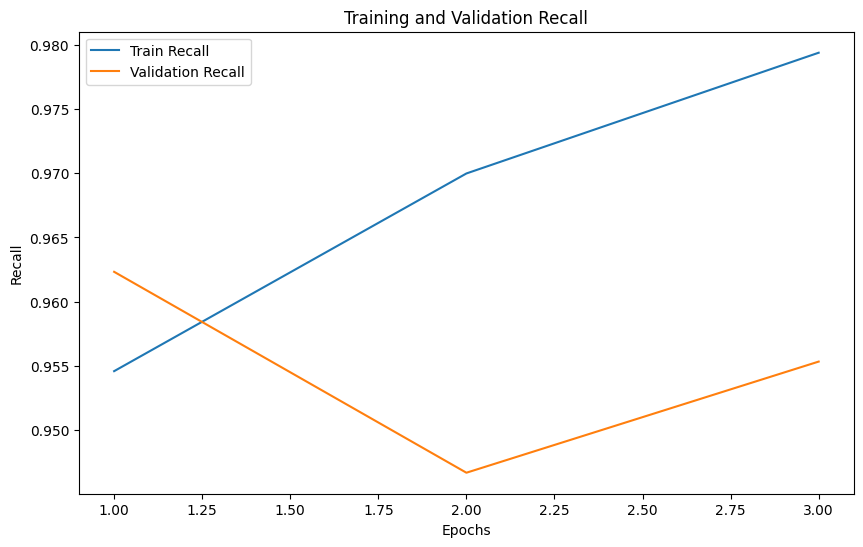

In [ ]:
# Plot training and validation metrics
epochs_range = range(1, len(bcl_acc_train) + 1)

# Plot Accuracy
plt.figure(figsize=(10, 6))
plt.plot(epochs_range, bcl_acc_train, label="Train Accuracy")
plt.plot(epochs_range, bcl_acc_val, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.savefig(f"/content/drive/My Drive/My Folder/Saved Models/Pretrained Models/BCL-HSD-73kPT-30k/Figures and Reports/training_validation_accuracy_73kPT_30k.png", bbox_inches="tight")
plt.show()

# Plot F1 Score
plt.figure(figsize=(10, 6))
plt.plot(epochs_range, bcl_f1_train, label="Train F1 Score")
plt.plot(epochs_range, bcl_f1_val, label="Validation F1 Score")
plt.xlabel("Epochs")
plt.ylabel("F1 Score")
plt.title("Training and Validation F1 Score")
plt.legend()
plt.savefig(f"/content/drive/My Drive/My Folder/Saved Models/Pretrained Models/BCL-HSD-73kPT-30k/Figures and Reports/training_validation_f1_score_73kPT_30k.png", bbox_inches="tight")
plt.show()

# Plot Precision
plt.figure(figsize=(10, 6))
plt.plot(epochs_range, bcl_pre_train, label="Train Precision")
plt.plot(epochs_range, bcl_pre_val, label="Validation Precision")
plt.xlabel("Epochs")
plt.ylabel("Precision")
plt.title("Training and Validation Precision")
plt.legend()
plt.savefig(f"/content/drive/My Drive/My Folder/Saved Models/Pretrained Models/BCL-HSD-73kPT-30k/Figures and Reports/training_validation_precision_73kPT_30k.png", bbox_inches="tight")
plt.show()

# Plot Recall
plt.figure(figsize=(10, 6))
plt.plot(epochs_range, bcl_rec_train, label="Train Recall")
plt.plot(epochs_range, bcl_rec_val, label="Validation Recall")
plt.xlabel("Epochs")
plt.ylabel("Recall")
plt.title("Training and Validation Recall")
plt.legend()
plt.savefig(f"/content/drive/My Drive/My Folder/Saved Models/Pretrained Models/BCL-HSD-73kPT-30k/Figures and Reports/training_validation_recall_73kPT_30k.png", bbox_inches="tight")
plt.show()

Evaluate

In [ ]:
def evaluate_model(model, test_loader):
    model.eval()
    predictions, true_labels = [], []

    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            outputs = model(input_ids, attention_mask)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            predictions.extend(preds)
            true_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions, average="weighted")
    precision = precision_score(true_labels, predictions, average="weighted")
    recall = recall_score(true_labels, predictions, average="weighted")

    # Generate confusion matrix for test set
    conf_matrix = confusion_matrix(true_labels, predictions)
    # Generate classification report
    report = classification_report(true_labels, predictions, target_names=['Non-Hate', 'Hate'])

    print(f"Accuracy: {acc}, F1: {f1}, Precision: {precision}, Recall: {recall}")
    return conf_matrix, report

In [ ]:
# Evaluate the model
conf_matrix, report = evaluate_model(trained_model, test_loader)

Accuracy: 0.9566666666666667, F1: 0.9568752709668491, Precision: 0.9574911893825867, Recall: 0.9566666666666667


Plot

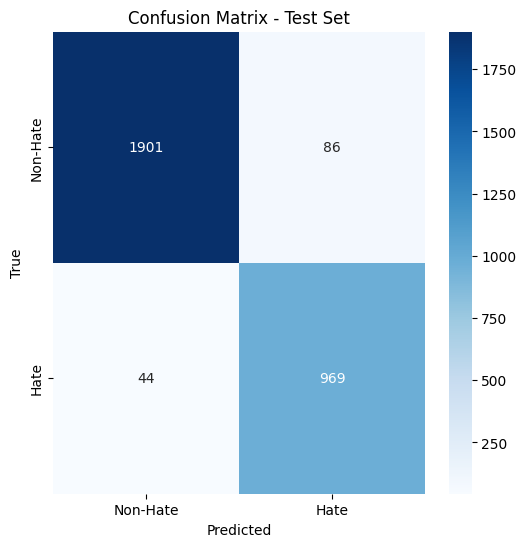

In [ ]:
# Plot confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Hate', 'Hate'], yticklabels=['Non-Hate', 'Hate'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Test Set')
plt.savefig(f"/content/drive/My Drive/My Folder/Saved Models/Pretrained Models/BCL-HSD-73kPT-30k/Figures and Reports/confusion_matrix_test_set_73kPT_30k.png", bbox_inches="tight")
plt.show()

In [ ]:
# Print classification report
print(report)
# Save the classification report as a text file
with open("/content/drive/My Drive/My Folder/Saved Models/Pretrained Models/BCL-HSD-73kPT-30k/Figures and Reports/classification_report_test_set_73kPT_30k.txt", "w") as f:
    f.write(report)

              precision    recall  f1-score   support

    Non-Hate       0.98      0.96      0.97      1987
        Hate       0.92      0.96      0.94      1013

    accuracy                           0.96      3000
   macro avg       0.95      0.96      0.95      3000
weighted avg       0.96      0.96      0.96      3000



Save Model in drive

In [ ]:
# Save the trained model
model_save_path = "/content/drive/My Drive/My Folder/Saved Models/Pretrained Models/BCL-HSD-73kPT-30k"

# Save model weights
torch.save(trained_model.state_dict(), f"{model_save_path}/pytorch_model.bin")

# Save tokenizer
tokenizer.save_pretrained(model_save_path)

# Save model config
config = {
    "model_type": "bert-cnn-bilstm",
    "bert_model_name": "csebuetnlp/banglabert",
    "num_labels": 2,
}
with open(f"{model_save_path}/config.json", "w") as f:
    json.dump(config, f)

Load model

In [ ]:
# Specify the model save path
model_save_path = "/content/drive/My Drive/My Folder/Saved Models/Pretrained Models/BCL-HSD-73kPT-30k"

# Load the configuration
with open(f"{model_save_path}/config.json", "r") as f:
    config = json.load(f)

# Reconstruct the model
model = BertCNNBiLSTM(
    bert_model_name=config["bert_model_name"],
    num_classes=config["num_labels"]
)

# Load the model weights
model.load_state_dict(torch.load(f"{model_save_path}/pytorch_model.bin", map_location=device))
model.to(device)
model.eval()

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_save_path)

<ipython-input-90-6a58d3592308>:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"{model_save_path}/pytorch_model.bin", map_location=devic

#73K Dataset

In [ ]:
bcl_acc_train = []
bcl_f1_train = []
bcl_pre_train = []
bcl_rec_train = []
bcl_acc_val = []
bcl_f1_val = []
bcl_pre_val = []
bcl_rec_val = []

In [ ]:
# Load the dataset
df = pd.read_csv("hf://datasets/Sky1241/hsban_merge_73k/merged_dataset73k.csv")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
df = df.dropna()
l = len(df.text)
n = Normalize()

for i in range (l):
    text = df.text[i]
    ct = n.normalize_text(text)
    if ct=='':
        df = df.drop([i])
    else:
        df.loc[i,'text'] = ct

dataset = Dataset.from_pandas(df)

Split dataset

In [ ]:
dataset = dataset.train_test_split(test_size=0.2)
test_data = dataset["test"].train_test_split(test_size=0.5)
train_data = dataset["train"]
valid_data = test_data["train"]
test_data = test_data["test"]

In [ ]:
print(len(train_data))
print(len(valid_data))
print(len(test_data))

58905
7363
7364


In [ ]:
class EarlyStopping:
    def __init__(self, patience=patience, mode="max", delta=0.001):
        self.patience = patience
        self.mode = mode
        self.delta = delta
        self.best_metric = None
        self.counter = 0
        self.stop_training = False

    def __call__(self, current_metric):
        if self.best_metric is None or (
            self.mode == "min" and current_metric < self.best_metric - self.delta
        ) or (
            self.mode == "max" and current_metric > self.best_metric + self.delta
        ):
            self.best_metric = current_metric
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.stop_training = True

In [ ]:
def compute_metrics(predictions, labels):
    acc = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average="weighted")
    precision = precision_score(labels, predictions, average="weighted")
    recall = recall_score(labels, predictions, average="weighted")
    return acc, f1, precision, recall

In [ ]:
class BertCNNBiLSTM(nn.Module):
    def __init__(self, bert_model_name, num_classes):
        super(BertCNNBiLSTM, self).__init__()
        self.bert = AutoModel.from_pretrained(bert_model_name)
        self.cnn = nn.Conv1d(in_channels=768, out_channels=128, kernel_size=3, padding=1)
        self.lstm = nn.LSTM(input_size=128, hidden_size=64, num_layers=1, bidirectional=True, batch_first=True)
        self.fc = nn.Linear(64 * 2, num_classes)
        self.dropout = nn.Dropout(0.3)

    def forward(self, input_ids, attention_mask):
        bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        hidden_states = bert_output.last_hidden_state
        cnn_output = self.cnn(hidden_states.transpose(1, 2))
        lstm_output, _ = self.lstm(cnn_output.transpose(1, 2))
        pooled_output = lstm_output[:, -1, :]
        output = self.fc(self.dropout(pooled_output))
        return output

Load Model

In [ ]:
# Load the model structure
bert_model_name = "csebuetnlp/banglabert"  # Pre-trained BERT model for tokenization
num_classes = 2

# Initialize the custom model
model = BertCNNBiLSTM(bert_model_name=bert_model_name, num_classes=num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=learning_rate)

# Download the model weights from Hugging Face Hub
weights_path = hf_hub_download(repo_id="nadiaafsara/BCL-HSD-30k", filename="pytorch_model.bin")

# Load the model weights into the model
model.load_state_dict(torch.load(weights_path, map_location=device))

# Move the model to the appropriate device (CPU or GPU)
model.to(device)

# Load the tokenizer for model from Hugging Face Hub
tokenizer = AutoTokenizer.from_pretrained("nadiaafsara/BCL-HSD-30k")

config.json:   0%|          | 0.00/586 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/443M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/442M [00:00<?, ?B/s]

<ipython-input-19-d262b89897ad>:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(weights_path, map_location=device))


tokenizer_config.json:   0%|          | 0.00/1.33k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/528k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.03M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

Tokenization

In [ ]:
# Tokenize the dataset
def tokenize_data(samples):
    return tokenizer(
        samples["text"],
        truncation=True,
        padding="max_length",
        max_length=128
    )

In [ ]:
# Apply tokenization to the datasets
train_data = train_data.map(tokenize_data, batched=True)
valid_data = valid_data.map(tokenize_data, batched=True)
test_data = test_data.map(tokenize_data, batched=True)

Map:   0%|          | 0/58905 [00:00<?, ? examples/s]

Map:   0%|          | 0/7363 [00:00<?, ? examples/s]

Map:   0%|          | 0/7364 [00:00<?, ? examples/s]

In [ ]:
print(train_data.column_names)
print(valid_data.column_names)
print(test_data.column_names)

['text', 'label', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask']
['text', 'label', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask']
['text', 'label', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask']


In [ ]:
# Remove unnecessary columns
train_data.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
valid_data.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
test_data.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

In [ ]:
# Define DataLoader
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=batch_size)

Train Model

In [ ]:
def train_model_with_early_stopping_and_metrics(
    model, train_loader, valid_loader, criterion, optimizer, epochs=epochs, patience=patience
):
    early_stopping = EarlyStopping(patience=patience, mode="max")  # Monitoring validation accuracy
    best_model_state = None
    best_epoch = 0

    for epoch in range(epochs):
        # Training phase
        model.train()
        train_predictions, train_labels = [], []
        total_loss = 0

        for batch in train_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            # Collect predictions and labels
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            train_predictions.extend(preds)
            train_labels.extend(labels.cpu().numpy())

        train_acc, train_f1, train_precision, train_recall = compute_metrics(train_predictions, train_labels)
        bcl_acc_train.append(train_acc )
        bcl_f1_train.append(train_f1)
        bcl_pre_train.append(train_precision)
        bcl_rec_train.append(train_recall)
        print(
            f"Epoch {epoch + 1}/{epochs}, Training Loss: {total_loss / len(train_loader):.4f}, "
            f"Accuracy: {train_acc:.4f}, F1: {train_f1:.4f}, Precision: {train_precision:.4f}, Recall: {train_recall:.4f}"
        )

        # Validation phase
        model.eval()
        valid_predictions, valid_labels = [], []
        valid_loss = 0

        with torch.no_grad():
            for batch in valid_loader:
                input_ids = batch["input_ids"].to(device)
                attention_mask = batch["attention_mask"].to(device)
                labels = batch["label"].to(device)
                outputs = model(input_ids, attention_mask)
                loss = criterion(outputs, labels)
                valid_loss += loss.item()

                # Collect predictions and labels
                preds = torch.argmax(outputs, dim=1).cpu().numpy()
                valid_predictions.extend(preds)
                valid_labels.extend(labels.cpu().numpy())

        valid_acc, valid_f1, valid_precision, valid_recall = compute_metrics(valid_predictions, valid_labels)
        bcl_acc_val.append(valid_acc)
        bcl_f1_val.append(valid_f1)
        bcl_pre_val.append(valid_precision)
        bcl_rec_val.append(valid_recall)
        print(
            f"Epoch {epoch + 1}/{epochs}, Validation Loss: {valid_loss / len(valid_loader):.4f}, "
            f"Accuracy: {valid_acc:.4f}, F1: {valid_f1:.4f}, Precision: {valid_precision:.4f}, Recall: {valid_recall:.4f}"
        )

        # Early stopping check
        early_stopping(valid_acc)
        if early_stopping.stop_training:
            print(f"Early stopping triggered at epoch {epoch + 1}")
            break

        # Save the best model state
        if early_stopping.best_metric == valid_acc:
            best_model_state = model.state_dict()
            best_epoch = epoch + 1

    # Restore the best model state
    if best_model_state:
        model.load_state_dict(best_model_state)
        print(f"Loaded the best model from epoch {best_epoch}")

    return model

In [ ]:
# Train the model
trained_model = train_model_with_early_stopping_and_metrics(
    model, train_loader, valid_loader, criterion, optimizer, epochs=epochs, patience=patience
)

Epoch 1/10, Training Loss: 0.2677, Accuracy: 0.8901, F1: 0.8899, Precision: 0.8900, Recall: 0.8901
Epoch 1/10, Validation Loss: 0.2494, Accuracy: 0.8984, F1: 0.8982, Precision: 0.8986, Recall: 0.8984
Epoch 2/10, Training Loss: 0.2113, Accuracy: 0.9135, F1: 0.9135, Precision: 0.9135, Recall: 0.9135
Epoch 2/10, Validation Loss: 0.2469, Accuracy: 0.9015, F1: 0.9016, Precision: 0.9016, Recall: 0.9015
Epoch 3/10, Training Loss: 0.1636, Accuracy: 0.9334, F1: 0.9334, Precision: 0.9335, Recall: 0.9334
Epoch 3/10, Validation Loss: 0.2716, Accuracy: 0.8999, F1: 0.9000, Precision: 0.9002, Recall: 0.8999
Epoch 4/10, Training Loss: 0.1279, Accuracy: 0.9478, F1: 0.9478, Precision: 0.9479, Recall: 0.9478
Epoch 4/10, Validation Loss: 0.2889, Accuracy: 0.9028, F1: 0.9028, Precision: 0.9028, Recall: 0.9028
Epoch 5/10, Training Loss: 0.1034, Accuracy: 0.9580, F1: 0.9580, Precision: 0.9581, Recall: 0.9580
Epoch 5/10, Validation Loss: 0.3323, Accuracy: 0.8984, F1: 0.8984, Precision: 0.8984, Recall: 0.8984


Plot

In [ ]:
os.makedirs("/content/drive/My Drive/My Folder/Saved Models/Pretrained Models/BCL-HSD-30kPT-73k/Figures and Reports", exist_ok=True)

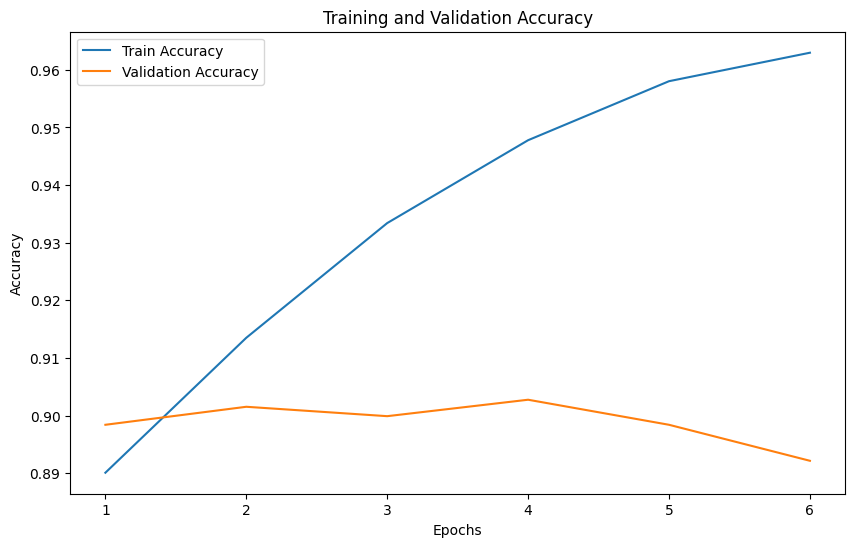

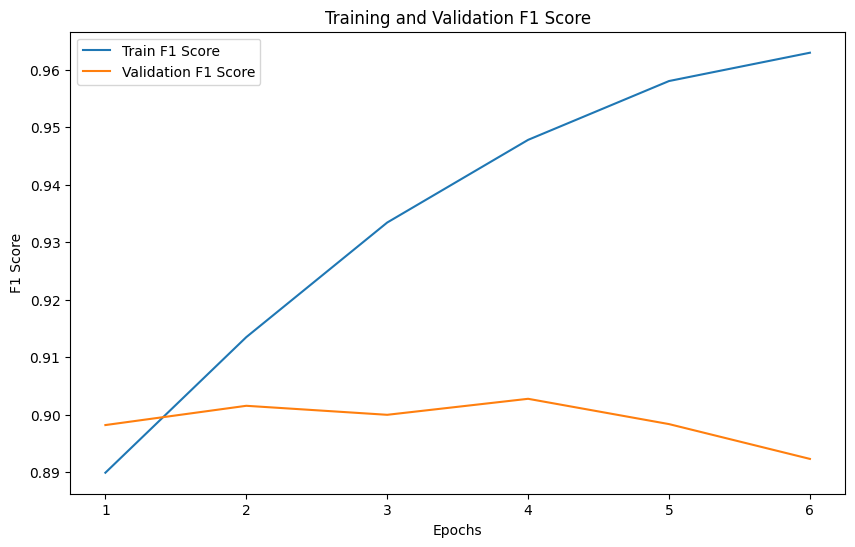

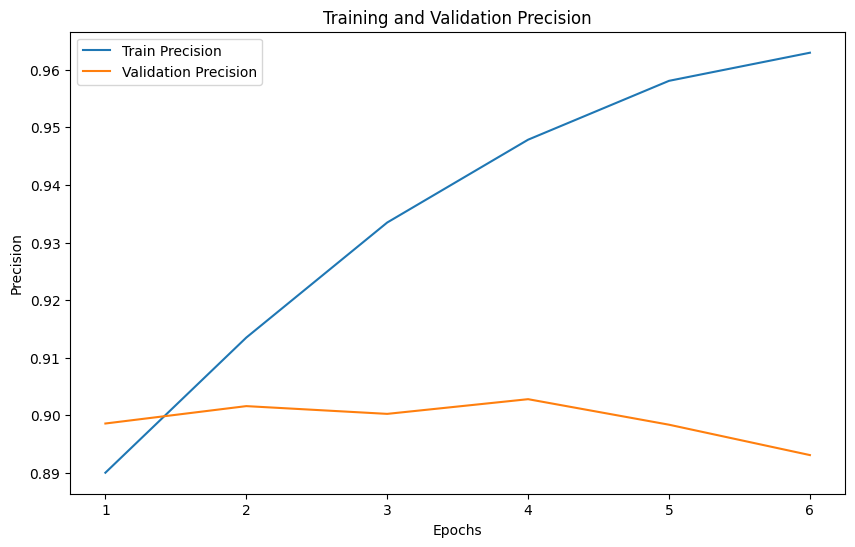

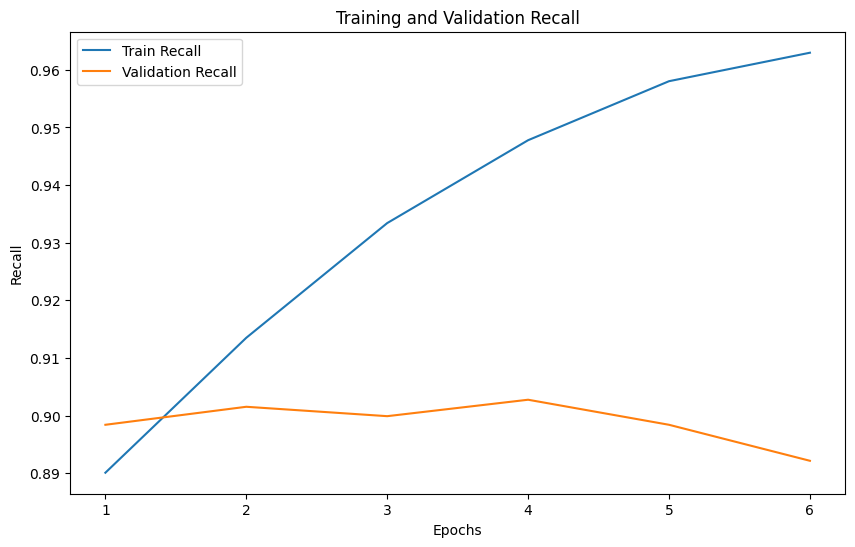

In [ ]:
# Plot training and validation metrics
epochs_range = range(1, len(bcl_acc_train) + 1)

# Plot Accuracy
plt.figure(figsize=(10, 6))
plt.plot(epochs_range, bcl_acc_train, label="Train Accuracy")
plt.plot(epochs_range, bcl_acc_val, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.savefig(f"/content/drive/My Drive/My Folder/Saved Models/Pretrained Models/BCL-HSD-30kPT-73k/Figures and Reports/training_validation_accuracy_30kPT_73k.png", bbox_inches="tight")
plt.show()

# Plot F1 Score
plt.figure(figsize=(10, 6))
plt.plot(epochs_range, bcl_f1_train, label="Train F1 Score")
plt.plot(epochs_range, bcl_f1_val, label="Validation F1 Score")
plt.xlabel("Epochs")
plt.ylabel("F1 Score")
plt.title("Training and Validation F1 Score")
plt.legend()
plt.savefig(f"/content/drive/My Drive/My Folder/Saved Models/Pretrained Models/BCL-HSD-30kPT-73k/Figures and Reports/training_validation_f1_score_30kPT_73k.png", bbox_inches="tight")
plt.show()

# Plot Precision
plt.figure(figsize=(10, 6))
plt.plot(epochs_range, bcl_pre_train, label="Train Precision")
plt.plot(epochs_range, bcl_pre_val, label="Validation Precision")
plt.xlabel("Epochs")
plt.ylabel("Precision")
plt.title("Training and Validation Precision")
plt.legend()
plt.savefig(f"/content/drive/My Drive/My Folder/Saved Models/Pretrained Models/BCL-HSD-30kPT-73k/Figures and Reports/training_validation_precision_30kPT_73k.png", bbox_inches="tight")
plt.show()

# Plot Recall
plt.figure(figsize=(10, 6))
plt.plot(epochs_range, bcl_rec_train, label="Train Recall")
plt.plot(epochs_range, bcl_rec_val, label="Validation Recall")
plt.xlabel("Epochs")
plt.ylabel("Recall")
plt.title("Training and Validation Recall")
plt.legend()
plt.savefig(f"/content/drive/My Drive/My Folder/Saved Models/Pretrained Models/BCL-HSD-30kPT-73k/Figures and Reports/training_validation_recall_30kPT_73k.png", bbox_inches="tight")  # Save the plot with tight bounding box
plt.show()

Evaluate

In [ ]:
def evaluate_model(model, test_loader):
    model.eval()
    predictions, true_labels = [], []

    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            outputs = model(input_ids, attention_mask)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            predictions.extend(preds)
            true_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions, average="weighted")
    precision = precision_score(true_labels, predictions, average="weighted")
    recall = recall_score(true_labels, predictions, average="weighted")

    # Generate confusion matrix for test set
    conf_matrix = confusion_matrix(true_labels, predictions)
    # Generate classification report
    report = classification_report(true_labels, predictions, target_names=['Non-Hate', 'Hate'])

    print(f"Accuracy: {acc}, F1: {f1}, Precision: {precision}, Recall: {recall}")
    return conf_matrix, report

In [ ]:
# Evaluate the model
conf_matrix, report = evaluate_model(trained_model, test_loader)

Accuracy: 0.892313959804454, F1: 0.8924842372561393, Precision: 0.893595506866908, Recall: 0.892313959804454


Plot

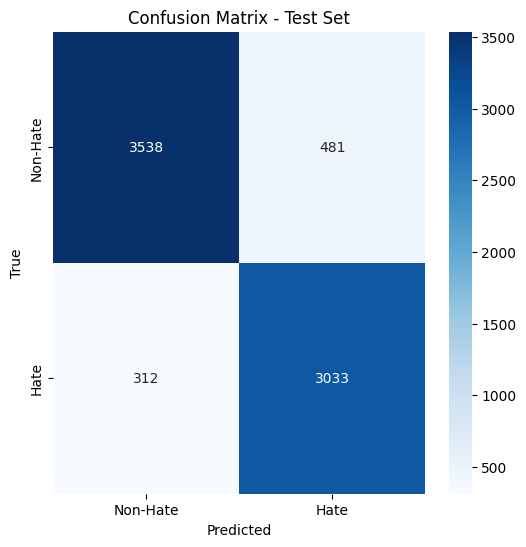

In [ ]:
# Plot confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Hate', 'Hate'], yticklabels=['Non-Hate', 'Hate'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Test Set')
plt.savefig(f"/content/drive/My Drive/My Folder/Saved Models/Pretrained Models/BCL-HSD-30kPT-73k/Figures and Reports/confusion_matrix_test_set_30kPT_73k.png", bbox_inches="tight")
plt.show()

In [ ]:
# Print classification report
print(report)
# Save the classification report as a text file
with open("/content/drive/My Drive/My Folder/Saved Models/Pretrained Models/BCL-HSD-30kPT-73k/Figures and Reports/classification_report_test_set_30kPT_73k.txt", "w") as f:
    f.write(report)

              precision    recall  f1-score   support

    Non-Hate       0.92      0.88      0.90      4019
        Hate       0.86      0.91      0.88      3345

    accuracy                           0.89      7364
   macro avg       0.89      0.89      0.89      7364
weighted avg       0.89      0.89      0.89      7364



Save In Drive

In [ ]:
# Save the trained model
model_save_path = "/content/drive/My Drive/My Folder/Saved Models/Pretrained Models/BCL-HSD-30kPT-73k"

# Save model weights
torch.save(trained_model.state_dict(), f"{model_save_path}/pytorch_model.bin")

# Save tokenizer
tokenizer.save_pretrained(model_save_path)

# Save model config
config = {
    "model_type": "bert-cnn-bilstm",
    "bert_model_name": "csebuetnlp/banglabert",
    "num_labels": 2,
}
with open(f"{model_save_path}/config.json", "w") as f:
    json.dump(config, f)

Load Model

In [ ]:
# Specify the model save path
model_save_path = "/content/drive/My Drive/My Folder/Saved Models/Pretrained Models/BCL-HSD-30kPT-73k"

# Load the configuration
with open(f"{model_save_path}/config.json", "r") as f:
    config = json.load(f)

# Reconstruct the model
model = BertCNNBiLSTM(
    bert_model_name=config["bert_model_name"],
    num_classes=config["num_labels"]
)

# Load the model weights
model.load_state_dict(torch.load(f"{model_save_path}/pytorch_model.bin", map_location=device))
model.to(device)
model.eval()

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_save_path)

<ipython-input-35-b3e3850561cf>:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"{model_save_path}/pytorch_model.bin", map_location=devic

#Plot Comparisons

#For 73K dataset

In [ ]:
metrics = {
    "Model": ["BanglaHateBert", "BanglaHateBert", "BanglaHateBert", "BanglaHateBert",
              "BCL-HSD (Base)","BCL-HSD (Base)","BCL-HSD (Base)","BCL-HSD (Base)",
              "BCL-HSD (Pretrained)", "BCL-HSD (Pretrained)", "BCL-HSD (Pretrained)", "BCL-HSD (Pretrained)"
              ],
    "Metric": ["Accuracy", "F1 Score", "Precision", "Recall",
               "Accuracy", "F1 Score", "Precision", "Recall",
               "Accuracy", "F1 Score", "Precision", "Recall"],
    "Score": [0.8711, 0.8705, 0.8720, 0.8711,  # BanglaHateBert
              0.8901, 0.8904, 0.8939, 0.8901,  # BCL-HSD (Base)
              0.8923, 0.8925, 0.8936, 0.8923]  # BCL-HSD (Pretrained)
}

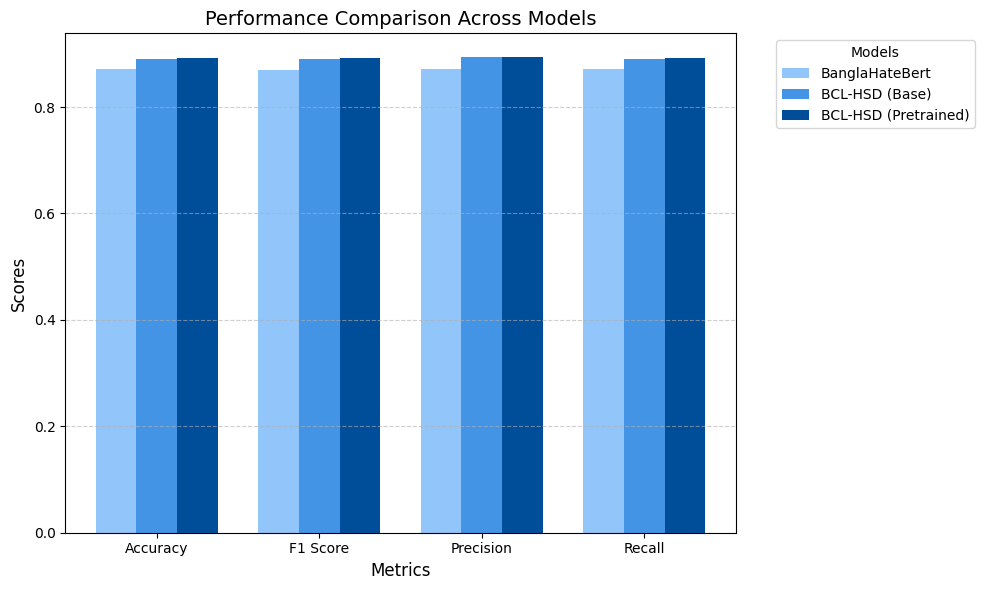

In [ ]:
# Extract scores for each model
metrics_labels = ["Accuracy", "F1 Score", "Precision", "Recall"]
banglahatebert_scores = metrics["Score"][:4]
bcl_hsd_base_scores = metrics["Score"][4:8]
bcl_hsd_pretrained_scores = metrics["Score"][8:12]

# Bar plot configuration
x = np.arange(len(metrics_labels))  # Metric indices
width = 0.25  # Bar width

# Plotting the bars
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(x - width, banglahatebert_scores, width, label="BanglaHateBert", color="#92C5F9")
ax.bar(x, bcl_hsd_base_scores, width, label="BCL-HSD (Base)", color="#4394E5")
ax.bar(x + width, bcl_hsd_pretrained_scores, width, label="BCL-HSD (Pretrained)", color="#004D99")

# Customize the plot
ax.set_xlabel("Metrics", fontsize=12)
ax.set_ylabel("Scores", fontsize=12)
ax.set_title("Performance Comparison Across Models", fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(metrics_labels)
ax.grid(axis="y", linestyle="--", alpha=0.6)

# Move the legend to the side
ax.legend(title="Models", loc="upper left", bbox_to_anchor=(1.05, 1), fontsize=10)

# Adjust layout
plt.tight_layout()

# Save the plot
save_path = "/content/drive/My Drive/My Folder/Saved Models/Pretrained Models/Figures and Reports"
os.makedirs(save_path, exist_ok=True)
plt.savefig(f"{save_path}/Compare 73K.png", bbox_inches="tight")
plt.show()

#Foe 30K dataset

In [ ]:
metrics = {
    "Model": ["BanglaHateBert", "BanglaHateBert", "BanglaHateBert", "BanglaHateBert",
              "BCL-HSD (Base)","BCL-HSD (Base)","BCL-HSD (Base)","BCL-HSD (Base)",
              "BCL-HSD (Pretrained)", "BCL-HSD (Pretrained)", "BCL-HSD (Pretrained)", "BCL-HSD (Pretrained)"
              ],
    "Metric": ["Accuracy", "F1 Score", "Precision", "Recall",
               "Accuracy", "F1 Score", "Precision", "Recall",
               "Accuracy", "F1 Score", "Precision", "Recall"],
    "Score": [0.887, 0.8872, 0.8875, 0.887,
              0.8957, 0.8966, 0.8991, 0.8957,
              0.9567, 0.9569, 0.9575, 0.9567]
}

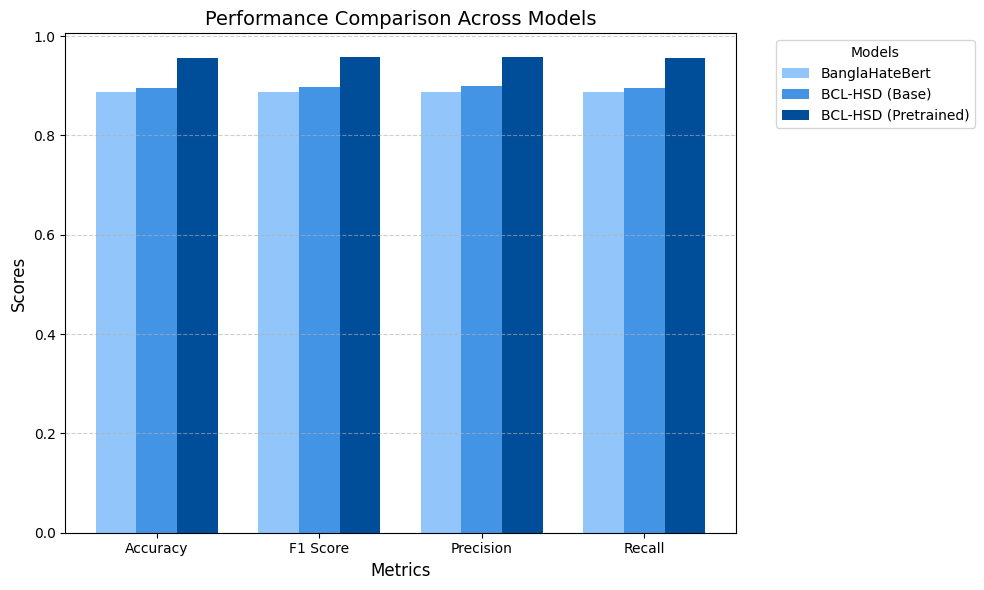

In [ ]:
# Extract scores for each model
metrics_labels = ["Accuracy", "F1 Score", "Precision", "Recall"]
banglahatebert_scores = metrics["Score"][:4]
bcl_hsd_base_scores = metrics["Score"][4:8]
bcl_hsd_pretrained_scores = metrics["Score"][8:12]

# Bar plot configuration
x = np.arange(len(metrics_labels))
width = 0.25  # Bar width

# Plotting the bars
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(x - width, banglahatebert_scores, width, label="BanglaHateBert", color="#92C5F9")
ax.bar(x, bcl_hsd_base_scores, width, label="BCL-HSD (Base)", color="#4394E5")
ax.bar(x + width, bcl_hsd_pretrained_scores, width, label="BCL-HSD (Pretrained)", color="#004D99")

# Customize the plot
ax.set_xlabel("Metrics", fontsize=12)
ax.set_ylabel("Scores", fontsize=12)
ax.set_title("Performance Comparison Across Models", fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(metrics_labels)
ax.grid(axis="y", linestyle="--", alpha=0.6)

# Move the legend to the side
ax.legend(title="Models", loc="upper left", bbox_to_anchor=(1.05, 1), fontsize=10)

# Adjust layout
plt.tight_layout()

# Save the plot
save_path = "/content/drive/My Drive/My Folder/Saved Models/Pretrained Models/Figures and Reports"
os.makedirs(save_path, exist_ok=True)
plt.savefig(f"{save_path}/Compare 30K.png", bbox_inches="tight")
plt.show()

